# Assessing Autism from Eye Movements Using Deep Learning: Professional Analysis Pipeline

**Author:** Tal Alfi  
**Advisor:** Prof. Ohad Ben-Shahar  
**Institution:** Ben-Gurion University of the Negev  
**Last Updated:** May 2025

---

## Table of Contents

1. [Quick Start](#1-quick-start)
2. [Configuration](#2-configuration)
3. [Environment Setup](#3-environment-setup)
4. [Data Overview](#4-data-overview)
5. [Preprocessing Functions](#5-preprocessing-functions)
6. [Visualization Functions](#6-visualization-functions)
7. [Complete Pipeline](#7-complete-pipeline)
8. [Batch Processing](#8-batch-processing)
9. [Feature Extraction](#9-feature-extraction)
10. [Export & Save](#10-export-save)
11. [Common Issues & Solutions](#11-common-issues)
12. [References & Resources](#12-references)

---

## Project Overview

This notebook implements a professional eye-tracking data preprocessing pipeline for autism spectrum disorder (ASD) research. The pipeline processes raw eye-tracking data from ~450 children watching 90-second social videos, preparing it for machine learning classification and severity prediction tasks.

### Key Features
- ✅ Robust preprocessing with binocular validation
- ✅ Automatic calibration correction
- ✅ Blink detection and interpolation  
- ✅ Outlier removal and smoothing
- ✅ Professional visualization tools
- ✅ Batch processing capabilities
- ✅ Comprehensive error handling

### Processing Flow
```
Raw Data → Validation → Calibration → Blink Handling → Outlier Removal → Clean Data
```

## 1. Quick Start

Process an eye-tracking *.asc file using edf parser by Tal Alfi into a CSV file

## 2. Configuration

All preprocessing parameters and constants in one place:

In [1]:
# === CONFIGURATION ===
# Screen parameters
SCREEN_WIDTH = 1280
SCREEN_HEIGHT = 1024
SCREEN_MARGIN = 500  # pixels outside screen to consider invalid

# Recording parameters
SAMPLING_RATE = 500  # Hz
RECORDING_DURATION = 90  # seconds
EXPECTED_SAMPLES = SAMPLING_RATE * RECORDING_DURATION

# Preprocessing parameters
PREPROCESSING_PARAMS = {
    # Blink detection
    'blink_gap_threshold': 5,      # samples to consider as gap
    'blink_window': 24,            # max samples for natural blink (~48ms)
    
    # Pupil validation
    'pupil_min': 200,              # minimum valid pupil size
    'pupil_max': 1200,             # maximum valid pupil size
    'pupil_smoothing_window': 250, # Gaussian smoothing window (500ms)
    'pupil_adaptation_time': 1.0,  # seconds to exclude at start
    
    # Binocular disparity
    'max_disparity': 150,          # maximum allowed disparity (pixels)
    'disparity_percentile': 50,    # percentile for calibration correction
    'velocity_threshold': 100,     # velocity threshold for stable periods
    
    # Missing data
    'missing_data_threshold': 0.95,# threshold to remove columns
    
    # Visualization
    'plot_sample_rate': 10,        # sample every N points for scatter plots
    'figure_dpi': 100,             # figure resolution
}

# File paths
DATA_DIR = 'files/'
OUTPUT_DIR = 'output/'
FIGURE_DIR = 'figures/'

# Analysis parameters
ANALYSIS_PARAMS = {
    'min_valid_data': 0.60,        # minimum 60% valid data required
    'window_size': 500,            # 1-second windows for temporal analysis
    'saccade_amplitude_bins': [0, 100, 500, 1000, 2000],  # pixels
}

# Visualization settings
VIZ_PARAMS = {
    'color_left': 'blue',
    'color_right': 'red',
    'alpha_scatter': 0.3,
    'alpha_line': 0.7,
    'figure_size': (12, 8),
    'grid_alpha': 0.3,
}

print("✅ Configuration loaded successfully")

✅ Configuration loaded successfully


## 3. Environment Setup

Import all required libraries and set up the analysis environment:

In [2]:
# Standard libraries
import os
import glob
import warnings
import json
from pathlib import Path
from datetime import datetime
from typing import Dict, List, Tuple, Optional, Union

# Data manipulation
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Rectangle, Circle
import plotly.graph_objects as go
import plotly.express as px

# Scientific computing
from scipy import stats, signal
from scipy.spatial import distance
from scipy.stats import entropy
from scipy.ndimage import gaussian_filter1d

# Machine Learning
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif

# Deep Learning (check availability)
try:
    import torch
    import torch.nn as nn
    import torch.optim as optim
    from torch.utils.data import Dataset, DataLoader
    DL_FRAMEWORK = 'pytorch'
    print("✅ PyTorch available for deep learning")
except ImportError:
    try:
        import tensorflow as tf
        from tensorflow import keras
        DL_FRAMEWORK = 'tensorflow'
        print("✅ TensorFlow available for deep learning")
    except ImportError:
        DL_FRAMEWORK = None
        print("⚠️ No deep learning framework found. Install PyTorch or TensorFlow.")

# Settings
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-darkgrid')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.float_format', '{:.2f}'.format)

# Set random seeds
np.random.seed(42)
if DL_FRAMEWORK == 'pytorch':
    torch.manual_seed(42)
elif DL_FRAMEWORK == 'tensorflow':
    tf.random.set_seed(42)

# Create output directories if they don't exist
for directory in [OUTPUT_DIR, FIGURE_DIR]:
    os.makedirs(directory, exist_ok=True)

print(f"✅ Environment setup complete!")
print(f"📁 Data directory: {DATA_DIR}")
print(f"📁 Output directory: {OUTPUT_DIR}")
print(f"📁 Figure directory: {FIGURE_DIR}")
print(f"📊 Available CSV files: {len(glob.glob(os.path.join(DATA_DIR, '*.csv')))}")

✅ PyTorch available for deep learning
✅ Environment setup complete!
📁 Data directory: files/
📁 Output directory: output/
📁 Figure directory: figures/
📊 Available CSV files: 7


## 4. Data Overview

Understanding the eye-tracking data structure and format:

In [3]:
def explore_data_structure(file_path: str) -> pd.DataFrame:
    """
    Load and explore the structure of an eye-tracking CSV file.
    
    Args:
        file_path: Path to CSV file
        
    Returns:
        pd.DataFrame: Loaded dataframe
    """
    # Load data
    df = pd.read_csv(file_path)
    
    # Extract subject ID from filename
    subject_id = os.path.basename(file_path).split('_')[0]
    
    print(f"📊 Data Structure Analysis")
    print(f"{'='*50}")
    print(f"Subject ID: {subject_id}")
    print(f"Total samples: {len(df):,}")
    print(f"Columns: {len(df.columns)}")
    
    # Check recording duration
    if 'timestamp' in df.columns:
        duration_ms = df['timestamp'].max() - df['timestamp'].min()
        duration_sec = duration_ms / 1000
        print(f"Recording duration: {duration_sec:.2f} seconds")
        print(f"Effective sampling rate: {len(df) / duration_sec:.2f} Hz")
    
    # Analyze missing data
    missing_summary = df.isnull().sum()
    missing_pct = (missing_summary / len(df) * 100).round(2)
    
    print(f"\n📋 Column Information:")
    print(f"{'Column':<25} {'Type':<10} {'Missing %':<10} {'Description'}")
    print(f"{'-'*70}")
    
    column_descriptions = {
        'timestamp': 'Recording timestamp (ms)',
        'frame_number': 'Video frame number',
        'x_left': 'Left eye X coordinate',
        'y_left': 'Left eye Y coordinate',
        'x_right': 'Right eye X coordinate',
        'y_right': 'Right eye Y coordinate',
        'pupil_left': 'Left pupil diameter',
        'pupil_right': 'Right pupil diameter',
        'is_fixation_left': 'Left eye fixation flag',
        'is_fixation_right': 'Right eye fixation flag',
        'is_saccade_left': 'Left eye saccade flag',
        'is_saccade_right': 'Right eye saccade flag',
        'is_blink_left': 'Left eye blink flag',
        'is_blink_right': 'Right eye blink flag',
    }
    
    for col in df.columns:
        desc = column_descriptions.get(col, 'Additional metric')
        print(f"{col:<25} {str(df[col].dtype):<10} {missing_pct[col]:<10.1f} {desc}")
    
    return df

# Example usage
if len(glob.glob(os.path.join(DATA_DIR, '*.csv'))) > 0:
    sample_file = glob.glob(os.path.join(DATA_DIR, '*.csv'))[0]
    df_sample = explore_data_structure(sample_file)

📊 Data Structure Analysis
Subject ID: 1024539343
Total samples: 45,010
Columns: 24
Recording duration: 90.02 seconds
Effective sampling rate: 500.01 Hz

📋 Column Information:
Column                    Type       Missing %  Description
----------------------------------------------------------------------
timestamp                 int64      0.0        Recording timestamp (ms)
frame_number              float64    0.0        Video frame number
x_left                    float64    1.1        Left eye X coordinate
y_left                    float64    1.1        Left eye Y coordinate
pupil_left                float64    1.1        Left pupil diameter
x_right                   float64    0.9        Right eye X coordinate
y_right                   float64    0.9        Right eye Y coordinate
pupil_right               float64    0.9        Right pupil diameter
input                     float64    100.0      Additional metric
cr_info                   object     99.5       Additional metric
cr_

## 5. Preprocessing Functions

All preprocessing functions organized by category:

### 5.1 Helper Functions

In [4]:
def add_helper_features(df: pd.DataFrame) -> pd.DataFrame:
    """
    Add helper features for preprocessing and analysis.
    
    Args:
        df: Input dataframe
        
    Returns:
        df: DataFrame with added features
    """
    df = df.copy()
    
    # Time in seconds from start
    df['time_seconds'] = (df['timestamp'] - df['timestamp'].iloc[0]) / 1000.0
    
    # Velocity calculation
    df['velocity_left'] = np.sqrt(
        df['x_left'].diff()**2 + df['y_left'].diff()**2
    ) * SAMPLING_RATE
    
    df['velocity_right'] = np.sqrt(
        df['x_right'].diff()**2 + df['y_right'].diff()**2
    ) * SAMPLING_RATE
    
    # Binocular disparity
    df['disparity_x'] = df['x_left'] - df['x_right']
    df['disparity_y'] = df['y_left'] - df['y_right']
    df['disparity_total'] = np.sqrt(
        df['disparity_x']**2 + df['disparity_y']**2
    )
    
    # Validity flags
    df['both_eyes_valid'] = (
        df['x_left'].notna() & df['x_right'].notna() &
        df['y_left'].notna() & df['y_right'].notna()
    )
    
    # Screen bounds check
    df['left_in_bounds'] = (
        (df['x_left'] >= -20) & (df['x_left'] <= SCREEN_WIDTH + 20) &
        (df['y_left'] >= -20) & (df['y_left'] <= SCREEN_HEIGHT + 20)
    )
    
    df['right_in_bounds'] = (
        (df['x_right'] >= -20) & (df['x_right'] <= SCREEN_WIDTH + 20) &
        (df['y_right'] >= -20) & (df['y_right'] <= SCREEN_HEIGHT + 20)
    )
    
    return df


def remove_empty_columns(df: pd.DataFrame, threshold: float = 0.95) -> pd.DataFrame:
    """
    Remove columns with more than threshold proportion of missing data.
    
    Args:
        df: Input dataframe
        threshold: Maximum allowed proportion of missing data
        
    Returns:
        df: DataFrame with empty columns removed
    """
    missing_proportion = df.isnull().sum() / len(df)
    cols_to_remove = missing_proportion[missing_proportion > threshold].index.tolist()
    
    if cols_to_remove:
        print(f"Removing {len(cols_to_remove)} columns with >{threshold*100:.0f}% missing data:")
        for col in cols_to_remove:
            print(f"  - {col}: {missing_proportion[col]*100:.1f}% missing")
    
    return df.drop(columns=cols_to_remove)

### 5.2 Binocular Processing Functions

In [5]:
def enforce_binocular_validity(df: pd.DataFrame) -> pd.DataFrame:
    """
    Enforce binocular data validity: if one eye's data is invalid, 
    mark both eyes as invalid for that sample.
    
    Args:
        df: Input dataframe
        
    Returns:
        df: DataFrame with enforced binocular validity
    """
    df = df.copy()
    
    # Find samples where only one eye has valid data
    left_valid = df['x_left'].notna() & df['y_left'].notna()
    right_valid = df['x_right'].notna() & df['y_right'].notna()
    
    # Identify monocular samples
    monocular_samples = (left_valid & ~right_valid) | (~left_valid & right_valid)
    
    print(f"Found {monocular_samples.sum()} monocular samples ({monocular_samples.sum()/len(df)*100:.1f}%)")
    
    # Invalidate monocular samples
    df.loc[monocular_samples, ['x_left', 'y_left', 'x_right', 'y_right']] = np.nan
    df.loc[monocular_samples, ['pupil_left', 'pupil_right']] = np.nan
    df.loc[monocular_samples, ['is_fixation_left', 'is_fixation_right']] = False
    df.loc[monocular_samples, ['is_saccade_left', 'is_saccade_right']] = False
    
    # Update validity flag
    df['both_eyes_valid'] = (
        df['x_left'].notna() & df['x_right'].notna() &
        df['y_left'].notna() & df['y_right'].notna()
    )
    
    print(f"After enforcement: {df['both_eyes_valid'].sum()} valid binocular samples ({df['both_eyes_valid'].sum()/len(df)*100:.1f}%)")
    
    return df


def automatic_binocular_calibration(
    df: pd.DataFrame,
    velocity_threshold: float = None,
    disparity_percentile: float = None,
    verbose: bool = True
) -> Tuple[pd.DataFrame, Dict]:
    """
    Automatically correct small alignment errors between left and right eyes.
    
    Args:
        df: Input dataframe
        velocity_threshold: Max velocity for stable periods (default from config)
        disparity_percentile: Percentile for bias estimation (default from config)
        verbose: Print calibration info
        
    Returns:
        df: Calibrated dataframe
        correction_info: Dictionary with calibration statistics
    """
    df = df.copy()
    
    # Use defaults from config if not provided
    if velocity_threshold is None:
        velocity_threshold = PREPROCESSING_PARAMS['velocity_threshold']
    if disparity_percentile is None:
        disparity_percentile = PREPROCESSING_PARAMS['disparity_percentile']
    
    # Ensure velocities are calculated
    if 'velocity_left' not in df.columns:
        df['velocity_left'] = np.sqrt(
            df['x_left'].diff()**2 + df['y_left'].diff()**2
        ) * SAMPLING_RATE
    
    if 'velocity_right' not in df.columns:
        df['velocity_right'] = np.sqrt(
            df['x_right'].diff()**2 + df['y_right'].diff()**2
        ) * SAMPLING_RATE
    
    # Find stable periods
    stable_mask = (
        (df['velocity_left'] < velocity_threshold) &
        (df['velocity_right'] < velocity_threshold) &
        df['both_eyes_valid']
    )
    
    stable_samples = stable_mask.sum()
    
    if stable_samples < 100:  # Need minimum samples for calibration
        if verbose:
            print("⚠️ Insufficient stable samples for calibration")
        return df, {'improvement_percent': 0}
    
    # Calculate disparities during stable periods
    stable_data = df[stable_mask]
    x_disparity = stable_data['x_left'] - stable_data['x_right']
    y_disparity = stable_data['y_left'] - stable_data['y_right']
    
    # Calculate robust bias estimates
    x_bias = np.percentile(x_disparity, disparity_percentile)
    y_bias = np.percentile(y_disparity, disparity_percentile)
    
    # Split correction between both eyes
    x_correction_left = x_bias / 2
    y_correction_left = y_bias / 2
    x_correction_right = -x_bias / 2
    y_correction_right = -y_bias / 2
    
    # Apply corrections
    df['x_left'] = df['x_left'] - x_correction_left
    df['y_left'] = df['y_left'] - y_correction_left
    df['x_right'] = df['x_right'] - x_correction_right
    df['y_right'] = df['y_right'] - y_correction_right
    
    # Recalculate disparities
    df['disparity_x'] = df['x_left'] - df['x_right']
    df['disparity_y'] = df['y_left'] - df['y_right']
    df['disparity_total'] = np.sqrt(
        df['disparity_x']**2 + df['disparity_y']**2
    )
    
    # Calculate improvement
    original_disparity = np.sqrt(x_disparity**2 + y_disparity**2).median()
    corrected_disparity = df.loc[stable_mask, 'disparity_total'].median()
    improvement = (1 - corrected_disparity / original_disparity) * 100
    
    correction_info = {
        'x_bias': x_bias,
        'y_bias': y_bias,
        'stable_samples': stable_samples,
        'original_disparity': original_disparity,
        'corrected_disparity': corrected_disparity,
        'improvement_percent': improvement,
    }
    
    if verbose:
        print("🔧 Automatic Binocular Calibration")
        print(f"  Detected bias: ({x_bias:.1f}, {y_bias:.1f}) pixels")
        print(f"  Based on {stable_samples:,} stable samples")
        print(f"  Disparity reduced: {original_disparity:.1f} → {corrected_disparity:.1f} pixels")
        print(f"  Improvement: {improvement:.1f}%")
    
    return df, correction_info


def remove_extreme_disparities(
    df: pd.DataFrame,
    max_disparity: float = None
) -> pd.DataFrame:
    """
    Remove samples with physiologically impossible binocular disparities.
    
    Args:
        df: Input dataframe
        max_disparity: Maximum allowed disparity (default from config)
        
    Returns:
        df: DataFrame with extreme disparities removed
    """
    df = df.copy()
    
    if max_disparity is None:
        max_disparity = PREPROCESSING_PARAMS['max_disparity']
    
    # Calculate disparity for valid samples
    both_valid = df['both_eyes_valid']
    
    # Find extreme disparities
    extreme_mask = both_valid & (df['disparity_total'] > max_disparity)
    n_extreme = extreme_mask.sum()
    
    print(f"Found {n_extreme} samples with extreme disparity (>{max_disparity} pixels)")
    print(f"That's {n_extreme/both_valid.sum()*100:.2f}% of previously valid data")
    
    # Invalidate extreme samples
    df.loc[extreme_mask, ['x_left', 'y_left', 'x_right', 'y_right']] = np.nan
    df.loc[extreme_mask, ['pupil_left', 'pupil_right']] = np.nan
    df.loc[extreme_mask, 'both_eyes_valid'] = False
    
    # Also check for out-of-bounds data
    out_of_bounds = both_valid & (
        (df['x_left'] < -SCREEN_MARGIN) | (df['x_left'] > SCREEN_WIDTH + SCREEN_MARGIN) |
        (df['y_left'] < -SCREEN_MARGIN) | (df['y_left'] > SCREEN_HEIGHT + SCREEN_MARGIN) |
        (df['x_right'] < -SCREEN_MARGIN) | (df['x_right'] > SCREEN_WIDTH + SCREEN_MARGIN) |
        (df['y_right'] < -SCREEN_MARGIN) | (df['y_right'] > SCREEN_HEIGHT + SCREEN_MARGIN)
    )
    n_oob = out_of_bounds.sum()
    
    if n_oob > 0:
        print(f"Found {n_oob} samples far outside screen bounds")
        df.loc[out_of_bounds, ['x_left', 'y_left', 'x_right', 'y_right']] = np.nan
        df.loc[out_of_bounds, 'both_eyes_valid'] = False
    
    # Update validity
    df['both_eyes_valid'] = (
        df['x_left'].notna() & df['x_right'].notna() &
        df['y_left'].notna() & df['y_right'].notna()
    )
    
    print(f"After filtering: {df['both_eyes_valid'].sum()} valid samples ({df['both_eyes_valid'].sum()/len(df)*100:.1f}%)")
    
    return df

### 5.3 Blink and Pupil Processing Functions

In [6]:
def detect_and_stabilize_noisy_eye(
    df: pd.DataFrame,
    noise_threshold: float = 3.0,
    outlier_threshold: float = 3.0,
    smoothing_method: str = 'savgol',
    verbose: bool = True
) -> pd.DataFrame:
    """
    Detect and stabilize noisy/shaky eye tracking data.
    Uses multiple approaches to identify and fix tracking artifacts.

    Args:
        df: Input dataframe
        noise_threshold: Ratio threshold to detect noisy eye
        outlier_threshold: Standard deviations for outlier detection
        smoothing_method: 'savgol', 'median', or 'kalman'
        verbose: Print stabilization info

    Returns:
        df: DataFrame with stabilized eye data
    """
    df = df.copy()

    # Calculate noise metrics for each eye
    def calculate_noise_metrics(x_col, y_col):
        # Method 1: Velocity variance (sudden changes)
        velocity = np.sqrt(df[x_col].diff()**2 + df[y_col].diff()**2)
        velocity_var = velocity.var()
        
        # Method 2: Acceleration variance (jerkiness)
        acceleration = velocity.diff().abs()
        accel_var = acceleration.var()
        
        # Method 3: High-frequency noise (second derivative)
        x_noise = df[x_col].diff().diff().abs().mean()
        y_noise = df[y_col].diff().diff().abs().mean()
        
        # Method 4: Outlier count (sudden large jumps)
        outliers = ((df[x_col].diff().abs() > df[x_col].diff().abs().quantile(0.95)) |
                   (df[y_col].diff().abs() > df[y_col].diff().abs().quantile(0.95))).sum()
        
        return {
            'velocity_var': velocity_var,
            'accel_var': accel_var,
            'noise_level': x_noise + y_noise,
            'outlier_count': outliers,
            'total_samples': len(df[x_col].dropna())
        }

    # Analyze both eyes
    left_metrics = calculate_noise_metrics('x_left', 'y_left')
    right_metrics = calculate_noise_metrics('x_right', 'y_right')
    
    # Determine which eye is noisier
    left_noise_score = (left_metrics['velocity_var'] + left_metrics['accel_var'] + 
                       left_metrics['noise_level'] + left_metrics['outlier_count'])
    right_noise_score = (right_metrics['velocity_var'] + right_metrics['accel_var'] + 
                        right_metrics['noise_level'] + right_metrics['outlier_count'])
    
    if verbose:
        print(f"👁️ Eye tracking quality analysis:")
        print(f"   Left eye noise score:  {left_noise_score:.2f}")
        print(f"   Right eye noise score: {right_noise_score:.2f}")
    
    # Identify noisy eye
    noisy_eye = None
    stable_eye = None
    noise_ratio = 1.0
    
    if left_noise_score > noise_threshold * right_noise_score:
        noisy_eye = 'left'
        stable_eye = 'right'
        noise_ratio = left_noise_score / right_noise_score
    elif right_noise_score > noise_threshold * left_noise_score:
        noisy_eye = 'right'
        stable_eye = 'left'
        noise_ratio = right_noise_score / left_noise_score
    
    if noisy_eye is None:
        if verbose:
            print(f"✓ Both eyes have similar tracking quality (ratio: {max(left_noise_score, right_noise_score) / min(left_noise_score, right_noise_score):.2f})")
        return df
    
    if verbose:
        print(f"⚠️ Detected noisy tracking in {noisy_eye} eye (noise ratio: {noise_ratio:.2f})")
        print(f"   Applying {smoothing_method} stabilization...")
    
    # Apply stabilization to noisy eye
    for coord in ['x', 'y']:
        noisy_col = f'{coord}_{noisy_eye}'
        stable_col = f'{coord}_{stable_eye}'
        
        if noisy_col not in df.columns or stable_col not in df.columns:
            continue
            
        # Get valid data
        valid_mask = df[noisy_col].notna() & df[stable_col].notna()
        if valid_mask.sum() < 50:
            continue
            
        noisy_data = df.loc[valid_mask, noisy_col].copy()
        stable_data = df.loc[valid_mask, stable_col].copy()
        
        # Method 1: Remove extreme outliers first
        median_val = noisy_data.median()
        mad = (noisy_data - median_val).abs().median()
        outlier_mask = (noisy_data - median_val).abs() > outlier_threshold * mad * 1.4826
        
        # Method 2: Apply different smoothing techniques
        if smoothing_method == 'savgol':
            # Savitzky-Golay filter - good for preserving features while smoothing
            from scipy.signal import savgol_filter
            window_length = min(21, len(noisy_data) // 10)
            if window_length % 2 == 0:
                window_length += 1
            if window_length >= 5:
                smoothed = savgol_filter(noisy_data.values, window_length, 3)
                noisy_data[:] = smoothed
                
        elif smoothing_method == 'median':
            # Adaptive median filter
            window_size = 7
            smoothed = noisy_data.rolling(window=window_size, center=True, min_periods=1).median()
            noisy_data[:] = smoothed
            
        elif smoothing_method == 'kalman':
            # Simple Kalman-like filter using the stable eye as reference
            alpha = 0.7  # Trust factor for stable eye
            beta = 0.3   # Trust factor for noisy eye
            
            # Weighted combination biased toward stable eye for very noisy samples
            disparity = (noisy_data - stable_data).abs()
            high_disparity = disparity > disparity.quantile(0.9)
            
            smoothed = noisy_data.copy()
            smoothed.loc[high_disparity] = (alpha * stable_data.loc[high_disparity] + 
                                          beta * noisy_data.loc[high_disparity])
            noisy_data[:] = smoothed
        
        # Method 3: Replace extreme outliers with interpolated values
        if outlier_mask.sum() > 0:
            noisy_data.loc[outlier_mask] = np.nan
            noisy_data = noisy_data.interpolate(method='linear')
        
        # Put smoothed data back
        df.loc[valid_mask, noisy_col] = noisy_data
    
    # Recalculate noise metrics to show improvement
    if verbose:
        new_metrics = calculate_noise_metrics(f'x_{noisy_eye}', f'y_{noisy_eye}')
        original_score = left_metrics if noisy_eye == 'left' else right_metrics
        improvement = (1 - new_metrics['noise_level'] / original_score['noise_level']) * 100
        print(f"   ✓ Noise reduced by {improvement:.1f}%")
    
    return df


def enforce_gaze_quality_constraints(
    df: pd.DataFrame,
    max_gaze_disparity: float = 100,
    verbose: bool = True
) -> pd.DataFrame:
    """
    Enforce gaze quality constraints: remove samples with excessive binocular disparity.
    For gaze data, we want both eyes looking at approximately the same screen location.

    Args:
        df: Input dataframe with gaze coordinates
        max_gaze_disparity: Maximum allowed gaze disparity in pixels (default 100px)
        verbose: Print constraint violations

    Returns:
        df: DataFrame with poor quality gaze samples removed
    """
    df = df.copy()

    # Find samples with excessive gaze disparity
    valid_mask = df['both_eyes_valid']
    
    if valid_mask.sum() == 0:
        if verbose:
            print("⚠️ No valid binocular samples to check")
        return df
    
    # Calculate gaze disparity for valid samples
    gaze_disparity = df.loc[valid_mask, 'disparity_total']
    
    # Find samples with excessive disparity
    excessive_disparity = valid_mask & (df['disparity_total'] > max_gaze_disparity)
    n_excessive = excessive_disparity.sum()
    
    if n_excessive > 0:
        if verbose:
            print(f"⚠️ Found {n_excessive} samples with excessive gaze disparity (>{max_gaze_disparity}px)")
            print(f"   ({n_excessive/valid_mask.sum()*100:.2f}% of valid data)")
            print("   → Removing poor quality gaze samples")

        # Invalidate excessive disparity samples
        df.loc[excessive_disparity, ['x_left', 'y_left', 'x_right', 'y_right']] = np.nan
        df.loc[excessive_disparity, 'both_eyes_valid'] = False

    # Update validity
    df['both_eyes_valid'] = (
        df['x_left'].notna() & df['x_right'].notna() &
        df['y_left'].notna() & df['y_right'].notna()
    )
    
    final_valid = df['both_eyes_valid'].sum()
    
    if verbose:
        # Show gaze disparity statistics
        remaining_disparity = df.loc[df['both_eyes_valid'], 'disparity_total']
        if len(remaining_disparity) > 0:
            print(f"\n📊 Gaze disparity statistics (remaining data):")
            print(f"   Mean: {remaining_disparity.mean():.1f}px")
            print(f"   Median: {remaining_disparity.median():.1f}px")
            print(f"   95th percentile: {remaining_disparity.quantile(0.95):.1f}px")
        
        print(f"\n✓ After gaze quality filtering: {final_valid} valid samples")

    return df


def detect_and_fix_eye_swap(
    df: pd.DataFrame,
    check_window: int = 1000,
    verbose: bool = True
) -> pd.DataFrame:
    """
    Detect if eye gaze labels were swapped during recording and fix if needed.
    For gaze data, we check if the "right eye" gaze is consistently to the left 
    of "left eye" gaze, which would indicate swapped labels.

    Args:
        df: Input dataframe
        check_window: Number of samples to check for swap detection
        verbose: Print swap detection info

    Returns:
        df: DataFrame with corrected eye labels
    """
    df = df.copy()

    # Check first valid window of data
    valid_samples = df[df['both_eyes_valid']].head(check_window)

    if len(valid_samples) < 100:
        if verbose:
            print("⚠️ Not enough valid samples to check for eye label swap")
        return df

    # For gaze data, check if there's a systematic bias in gaze positions
    # If eyes are consistently swapped, we might see the "right eye" gaze 
    # systematically to the left of "left eye" gaze
    x_diff = valid_samples['x_right'] - valid_samples['x_left']
    
    # Calculate how often right eye gaze is to the right of left eye gaze
    right_of_left_count = (x_diff > 0).sum()
    right_ratio = right_of_left_count / len(valid_samples)

    if verbose:
        print(f"✓ Gaze label check: {right_ratio*100:.1f}% of samples have right eye gaze to the right of left eye gaze")
        print(f"   Mean horizontal gaze difference: {x_diff.mean():.1f}px")

    # Only swap if there's a very strong systematic bias (>80% reversed)
    if right_ratio < 0.2:  # Less than 20% have correct orientation
        if verbose:
            print(f"🔄 Systematic gaze label swap detected!")
            print("   → Swapping eye labels throughout recording")

        # Swap all eye-related columns
        swap_columns = [
            ('x_left', 'x_right'),
            ('y_left', 'y_right'),
            ('pupil_left', 'pupil_right'),
            ('is_fixation_left', 'is_fixation_right'),
            ('is_saccade_left', 'is_saccade_right'),
            ('is_blink_left', 'is_blink_right'),
            ('velocity_left', 'velocity_right'),
        ]

        for left_col, right_col in swap_columns:
            if left_col in df.columns and right_col in df.columns:
                df[left_col], df[right_col] = df[right_col].copy(), df[left_col].copy()

        # Recalculate disparity
        df['disparity_x'] = df['x_left'] - df['x_right']
        df['disparity_y'] = df['y_left'] - df['y_right']
        df['disparity_total'] = np.sqrt(df['disparity_x']**2 + df['disparity_y']**2)

        if verbose:
            print("   ✓ Eye labels corrected")
    
    return df

In [7]:
def detect_and_handle_blinks(
    df: pd.DataFrame,
    gap_threshold: int = None,
    blink_window: int = None,
    verbose: bool = True
) -> Tuple[pd.DataFrame, Dict]:
    """
    Detect and handle blinks in eye-tracking data.
    Technical gaps (>threshold) are marked as NaN.
    Natural blinks (≤window) are interpolated.
    
    Args:
        df: Input dataframe
        gap_threshold: Samples to consider as gap (default from config)
        blink_window: Max samples for natural blink (default from config)
        verbose: Print blink statistics
        
    Returns:
        df: DataFrame with blinks handled
        blink_stats: Dictionary with blink statistics
    """
    df = df.copy()
    
    # Use defaults from config
    if gap_threshold is None:
        gap_threshold = PREPROCESSING_PARAMS['blink_gap_threshold']
    if blink_window is None:
        blink_window = PREPROCESSING_PARAMS['blink_window']
    
    # Initialize blink columns if not present
    for col in ['is_blink_left', 'is_blink_right']:
        if col not in df.columns:
            df[col] = False
    
    # Function to find consecutive missing periods
    def find_missing_periods(missing_mask):
        periods = []
        in_period = False
        start_idx = 0
        
        for i, is_missing in enumerate(missing_mask):
            if is_missing and not in_period:
                start_idx = i
                in_period = True
            elif not is_missing and in_period:
                periods.append((start_idx, i - 1))
                in_period = False
        
        if in_period:
            periods.append((start_idx, len(missing_mask) - 1))
        
        return periods
    
    # Process each eye
    blink_stats = {}
    
    for eye in ['left', 'right']:
        missing = df[f'x_{eye}'].isna() | df[f'y_{eye}'].isna()
        periods = find_missing_periods(missing)
        
        technical_gaps = 0
        natural_blinks = 0
        interpolated_samples = 0
        
        for start, end in periods:
            duration = end - start + 1
            
            if gap_threshold < duration <= blink_window:
                # Natural blink - interpolate
                if start > 0 and end < len(df) - 1:
                    # Linear interpolation
                    for col in [f'x_{eye}', f'y_{eye}']:
                        df.loc[start:end, col] = np.interp(
                            np.arange(start, end + 1),
                            [start - 1, end + 1],
                            [df.loc[start - 1, col], df.loc[end + 1, col]]
                        )
                    # Mark as blink
                    df.loc[start:end, f'is_blink_{eye}'] = True
                    natural_blinks += 1
                    interpolated_samples += duration
            elif duration > blink_window:
                # Technical gap
                technical_gaps += 1
        
        blink_stats[f'{eye}_eye'] = {
            'technical_gaps': technical_gaps,
            'natural_blinks': natural_blinks,
            'interpolated_samples': interpolated_samples
        }
    
    # Update validity
    df['both_eyes_valid'] = (
        df['x_left'].notna() & df['x_right'].notna() &
        df['y_left'].notna() & df['y_right'].notna()
    )
    
    if verbose:
        print("👁️ Blink Detection and Handling")
        print(f"  Left eye: {blink_stats['left_eye']['natural_blinks']} blinks, "
              f"{blink_stats['left_eye']['technical_gaps']} gaps")
        print(f"  Right eye: {blink_stats['right_eye']['natural_blinks']} blinks, "
              f"{blink_stats['right_eye']['technical_gaps']} gaps")
    
    return df, blink_stats


def preprocess_pupil_size(
    df: pd.DataFrame,
    min_pupil: float = None,
    max_pupil: float = None,
    window_size: int = None,
    verbose: bool = True
) -> Tuple[pd.DataFrame, Dict]:
    """
    Preprocess pupil size data by removing implausible values and smoothing.
    
    Args:
        df: Input dataframe
        min_pupil: Minimum valid pupil size (default from config)
        max_pupil: Maximum valid pupil size (default from config)
        window_size: Gaussian smoothing window (default from config)
        verbose: Print pupil statistics
        
    Returns:
        df: DataFrame with preprocessed pupil data
        pupil_stats: Dictionary with pupil statistics
    """
    df = df.copy()
    
    # Use defaults from config
    if min_pupil is None:
        min_pupil = PREPROCESSING_PARAMS['pupil_min']
    if max_pupil is None:
        max_pupil = PREPROCESSING_PARAMS['pupil_max']
    if window_size is None:
        window_size = PREPROCESSING_PARAMS['pupil_smoothing_window']
    
    adaptation_samples = int(PREPROCESSING_PARAMS['pupil_adaptation_time'] * SAMPLING_RATE)
    
    pupil_stats = {}
    
    for eye in ['left', 'right']:
        col = f'pupil_{eye}'
        if col not in df.columns:
            continue
        
        original_data = df[col].copy()
        
        # Count implausible values
        zero_pupils = (original_data == 0).sum()
        too_small = ((original_data > 0) & (original_data < min_pupil)).sum()
        too_large = (original_data > max_pupil).sum()
        
        # Remove implausible values
        df.loc[(df[col] == 0) | (df[col] < min_pupil) | (df[col] > max_pupil), col] = np.nan
        
        # Exclude adaptation period
        if len(df) > adaptation_samples:
            df.loc[:adaptation_samples-1, col] = np.nan
        
        # Detect and remove sharp changes
        if df[col].notna().sum() > 10:
            pupil_diff = df[col].diff().abs()
            threshold = pupil_diff.quantile(0.99)
            sharp_changes = pupil_diff > threshold
            sharp_change_count = sharp_changes.sum()
            df.loc[sharp_changes, col] = np.nan
        else:
            sharp_change_count = 0
        
        # Apply Gaussian smoothing
        valid_mask = df[col].notna()
        if valid_mask.sum() > window_size:
            valid_indices = np.where(valid_mask)[0]
            valid_values = df.loc[valid_mask, col].values
            
            # Apply smoothing
            sigma = window_size / 4
            smoothed_values = gaussian_filter1d(valid_values, sigma=sigma, mode='nearest')
            
            # Put smoothed values back
            df.loc[valid_indices, col] = smoothed_values
        
        # Calculate statistics
        final_valid = df[col].notna().sum()
        original_valid = original_data.notna().sum()
        
        pupil_stats[f'{eye}_eye'] = {
            'original_valid': original_valid,
            'zero_pupils': zero_pupils,
            'too_small': too_small,
            'too_large': too_large,
            'sharp_changes': sharp_change_count,
            'final_valid': final_valid,
            'removed_total': original_valid - final_valid,
            'removal_percentage': (original_valid - final_valid) / original_valid * 100 if original_valid > 0 else 0
        }
    
    if verbose:
        print("👁️ Pupil Size Preprocessing")
        for eye in ['left', 'right']:
            if f'{eye}_eye' in pupil_stats:
                stats = pupil_stats[f'{eye}_eye']
                print(f"  {eye.capitalize()} eye: {stats['removal_percentage']:.1f}% removed "
                      f"({stats['final_valid']:,} valid samples)")
    
    return df, pupil_stats


def round_coordinates_to_pixels(df: pd.DataFrame, verbose: bool = True) -> pd.DataFrame:
    """
    Round eye position values to whole numbers (integer pixels).
    
    Args:
        df: Input dataframe
        verbose: Print rounding info
        
    Returns:
        df: DataFrame with rounded coordinates
    """
    df = df.copy()
    
    coord_columns = ['x_left', 'y_left', 'x_right', 'y_right']
    
    # Round coordinates
    for col in coord_columns:
        if col in df.columns:
            df[col] = df[col].round().astype('Int64')  # Nullable integer
    
    if verbose:
        print("🎯 Coordinates rounded to integer pixels")
    
    return df

## 6. Visualization Functions

Reusable visualization components for eye-tracking data:

In [8]:
def plot_before_after(
    df_before: pd.DataFrame,
    df_after: pd.DataFrame,
    feature: str,
    title: str = None,
    figsize: Tuple[int, int] = None
) -> plt.Figure:
    """
    Generic before/after comparison plot for any feature.
    
    Args:
        df_before: Original dataframe
        df_after: Processed dataframe
        feature: Feature column to plot
        title: Plot title
        figsize: Figure size
        
    Returns:
        fig: Matplotlib figure
    """
    if figsize is None:
        figsize = VIZ_PARAMS['figure_size']
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
    
    # Before plot
    if feature in df_before.columns:
        ax1.plot(df_before['time_seconds'], df_before[feature],
                 alpha=VIZ_PARAMS['alpha_line'], linewidth=0.5)
        ax1.set_title(f'Before: {feature}')
        ax1.set_xlabel('Time (seconds)')
        ax1.set_ylabel(feature)
        ax1.grid(True, alpha=VIZ_PARAMS['grid_alpha'])
    
    # After plot
    if feature in df_after.columns:
        ax2.plot(df_after['time_seconds'], df_after[feature],
                 alpha=VIZ_PARAMS['alpha_line'], linewidth=0.5)
        ax2.set_title(f'After: {feature}')
        ax2.set_xlabel('Time (seconds)')
        ax2.set_ylabel(feature)
        ax2.grid(True, alpha=VIZ_PARAMS['grid_alpha'])
    
    if title:
        fig.suptitle(title, fontsize=14)
    
    plt.tight_layout()
    return fig


def plot_gaze_trajectory(
    df: pd.DataFrame,
    eye: str = 'both',
    sample_rate: int = None,
    ax: plt.Axes = None,
    title: str = None
) -> Union[plt.Figure, plt.Axes]:
    """
    Plot gaze trajectory for one or both eyes.
    
    Args:
        df: DataFrame with eye tracking data
        eye: 'left', 'right', or 'both'
        sample_rate: Sample every N points (default from config)
        ax: Existing axis to plot on
        title: Plot title
        
    Returns:
        fig or ax: Figure if ax is None, otherwise axis
    """
    if sample_rate is None:
        sample_rate = PREPROCESSING_PARAMS['plot_sample_rate']
    
    if ax is None:
        fig, ax = plt.subplots(figsize=VIZ_PARAMS['figure_size'])
        return_fig = True
    else:
        return_fig = False
    
    # Sample data to avoid overplotting
    sampled_df = df[::sample_rate]
    
    # Plot eye data
    if eye in ['left', 'both']:
        valid = sampled_df.dropna(subset=['x_left', 'y_left'])
        ax.scatter(valid['x_left'], valid['y_left'],
                   c=VIZ_PARAMS['color_left'], alpha=VIZ_PARAMS['alpha_scatter'],
                   s=1, label='Left eye')
    
    if eye in ['right', 'both']:
        valid = sampled_df.dropna(subset=['x_right', 'y_right'])
        ax.scatter(valid['x_right'], valid['y_right'],
                   c=VIZ_PARAMS['color_right'], alpha=VIZ_PARAMS['alpha_scatter'],
                   s=1, label='Right eye')
    
    # Add screen boundaries
    screen_rect = Rectangle((0, 0), SCREEN_WIDTH, SCREEN_HEIGHT,
                            fill=False, edgecolor='black', linewidth=2)
    ax.add_patch(screen_rect)
    
    # Set limits and labels
    margin = 100
    ax.set_xlim(-margin, SCREEN_WIDTH + margin)
    ax.set_ylim(-margin, SCREEN_HEIGHT + margin)
    ax.invert_yaxis()  # Invert Y axis for screen coordinates
    ax.set_xlabel('X coordinate (pixels)')
    ax.set_ylabel('Y coordinate (pixels)')
    
    if title:
        ax.set_title(title)
    else:
        ax.set_title(f'Gaze Trajectory ({eye.capitalize()} eye)')
    
    ax.legend()
    ax.grid(True, alpha=VIZ_PARAMS['grid_alpha'])
    ax.set_aspect('equal', adjustable='box')
    
    return fig if return_fig else ax


def plot_disparity_analysis(
    df: pd.DataFrame,
    figsize: Tuple[int, int] = (15, 10)
) -> plt.Figure:
    """
    Comprehensive binocular disparity analysis plot.
    
    Args:
        df: DataFrame with disparity data
        figsize: Figure size
        
    Returns:
        fig: Matplotlib figure
    """
    fig, axes = plt.subplots(2, 2, figsize=figsize)
    
    # 1. Disparity over time
    ax = axes[0, 0]
    ax.plot(df['time_seconds'], df['disparity_total'],
            color='purple', alpha=0.7, linewidth=0.5)
    ax.axhline(y=10, color='green', linestyle='--', label='Good (<10 px)')
    ax.axhline(y=30, color='orange', linestyle='--', label='Acceptable (<30 px)')
    ax.axhline(y=50, color='red', linestyle='--', label='Poor (>50 px)')
    ax.set_ylabel('Binocular Disparity (pixels)')
    ax.set_xlabel('Time (seconds)')
    ax.set_title('Disparity Throughout Recording')
    ax.set_ylim(0, min(200, df['disparity_total'].quantile(0.99) * 1.1))
    ax.legend()
    ax.grid(True, alpha=VIZ_PARAMS['grid_alpha'])
    
    # 2. Disparity distribution
    ax = axes[0, 1]
    valid_disparity = df['disparity_total'].dropna()
    ax.hist(valid_disparity, bins=50, color='purple', alpha=0.7, edgecolor='black')
    ax.axvline(x=valid_disparity.median(), color='red', linestyle='--',
               label=f'Median: {valid_disparity.median():.1f} px')
    ax.axvline(x=valid_disparity.mean(), color='blue', linestyle='--',
               label=f'Mean: {valid_disparity.mean():.1f} px')
    ax.set_xlabel('Disparity (pixels)')
    ax.set_ylabel('Frequency')
    ax.set_title('Disparity Distribution')
    ax.legend()
    ax.grid(True, alpha=VIZ_PARAMS['grid_alpha'])
    
    # 3. Disparity pattern (X vs Y) with TIME COLORBAR and ABSOLUTE VALUES
    ax = axes[1, 0]
    sample_data = df[::PREPROCESSING_PARAMS['plot_sample_rate']].dropna(
        subset=['disparity_x', 'disparity_y'])
    
    if len(sample_data) > 0:
        # Use absolute values for disparities
        abs_disparity_x = sample_data['disparity_x'].abs()
        abs_disparity_y = sample_data['disparity_y'].abs()
        
        scatter = ax.scatter(abs_disparity_x, abs_disparity_y,
                             alpha=0.6, s=8, c=sample_data['time_seconds'], 
                             cmap='viridis', edgecolors='none')
        
        # Add colorbar for time reference
        cbar = plt.colorbar(scatter, ax=ax, shrink=0.8)
        cbar.set_label('Time (seconds)', rotation=270, labelpad=15)
        
        # Add reference circles (now from origin since all values are positive)
        for radius, color in [(10, 'green'), (30, 'orange'), (50, 'red')]:
            circle = Circle((0, 0), radius, fill=False, color=color,
                            linestyle='--', alpha=0.7, linewidth=2)
            ax.add_patch(circle)
        
        ax.set_xlabel('Absolute Horizontal Disparity (pixels)')
        ax.set_ylabel('Absolute Vertical Disparity (pixels)')
        ax.set_title('Binocular Disparity Pattern (absolute values, colored by time)')
        ax.set_aspect('equal', adjustable='box')
        ax.grid(True, alpha=VIZ_PARAMS['grid_alpha'])
        
        # Set limits to start from 0
        ax.set_xlim(0, max(abs_disparity_x.max() * 1.1, 100))
        ax.set_ylim(0, max(abs_disparity_y.max() * 1.1, 100))
    
    # 4. Validity over time
    ax = axes[1, 1]
    window_size = ANALYSIS_PARAMS['window_size']
    validity_over_time = []
    time_points = []
    
    for i in range(0, len(df) - window_size, window_size // 2):
        window = df.iloc[i:i+window_size]
        validity_percent = window['both_eyes_valid'].sum() / len(window) * 100
        validity_over_time.append(validity_percent)
        time_points.append(window['time_seconds'].mean())
    
    ax.plot(time_points, validity_over_time, 'g-', linewidth=2)
    ax.axhline(y=60, color='orange', linestyle='--', label='60% threshold')
    ax.axhline(y=80, color='green', linestyle='--', label='80% threshold')
    ax.set_xlabel('Time (seconds)')
    ax.set_ylabel('Data Validity (%)')
    ax.set_title('Data Validity Over Time (1-second windows)')
    ax.set_ylim(0, 105)
    ax.legend()
    ax.grid(True, alpha=VIZ_PARAMS['grid_alpha'])
    
    plt.suptitle('Binocular Eye-Tracking Quality Analysis', fontsize=16)
    plt.tight_layout()
    
    return fig


def plot_preprocessing_summary(
    preprocessing_info: Dict,
    save_path: str = None
) -> plt.Figure:
    """
    Create a summary plot of preprocessing statistics.
    
    Args:
        preprocessing_info: Dictionary with preprocessing statistics
        save_path: Optional path to save figure
        
    Returns:
        fig: Matplotlib figure
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    
    # Data retention through pipeline
    steps = ['Initial', 'Blinks', 'Binocular', 'Calibration', 'Disparity', 'Final']
    values = [
        preprocessing_info['initial_samples'],
        preprocessing_info['steps'].get('after_blinks', preprocessing_info['initial_samples']),
        preprocessing_info['steps']['after_binocular'],
        preprocessing_info['steps']['after_calibration'],
        preprocessing_info['steps']['after_disparity'],
        preprocessing_info['final_valid_samples']
    ]
    
    ax1.plot(steps, values, 'o-', linewidth=2, markersize=8)
    ax1.set_ylabel('Valid Samples')
    ax1.set_title('Data Retention Through Pipeline')
    ax1.grid(True, alpha=0.3)
    
    # Add percentage labels
    for i, (step, value) in enumerate(zip(steps, values)):
        percent = value / preprocessing_info['initial_samples'] * 100
        ax1.text(i, value + 500, f'{percent:.1f}%', ha='center', va='bottom')
    
    # Preprocessing impact breakdown
    categories = ['Blinks\nInterpolated', 'Monocular\nRemoved', 'Extreme\nDisparity', 'Other']
    
    blink_impact = (preprocessing_info['blink_stats']['left_eye']['interpolated_samples'] +
                    preprocessing_info['blink_stats']['right_eye']['interpolated_samples']) / 2
    
    impacts = [
        blink_impact,
        preprocessing_info['initial_samples'] - preprocessing_info['steps']['after_binocular'],
        preprocessing_info['steps']['after_calibration'] - preprocessing_info['steps']['after_disparity'],
        preprocessing_info['initial_samples'] - preprocessing_info['final_valid_samples'] - 
        (preprocessing_info['initial_samples'] - preprocessing_info['steps']['after_binocular']) -
        (preprocessing_info['steps']['after_calibration'] - preprocessing_info['steps']['after_disparity'])
    ]
    
    # Ensure no negative values
    impacts = [max(0, impact) for impact in impacts]
    
    ax2.bar(categories, impacts, color=['green', 'orange', 'red', 'gray'])
    ax2.set_ylabel('Samples Affected')
    ax2.set_title('Preprocessing Impact by Category')
    ax2.grid(True, alpha=0.3, axis='y')
    
    # Overall title
    retention_rate = preprocessing_info['retention_rate']
    plt.suptitle(f'Preprocessing Summary - {retention_rate:.1f}% Data Retained', fontsize=14)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=PREPROCESSING_PARAMS['figure_dpi'], bbox_inches='tight')
    
    return fig

In [9]:
def plot_pupil_analysis(
    df_before: pd.DataFrame,
    df_after: pd.DataFrame,
    figsize: Tuple[int, int] = (18, 14)
) -> plt.Figure:
    """
    Comprehensive pupil size analysis showing before/after preprocessing.
    
    Args:
        df_before: Original dataframe
        df_after: Preprocessed dataframe
        figsize: Figure size
        
    Returns:
        fig: Matplotlib figure
    """
    fig, axes = plt.subplots(3, 2, figsize=figsize)
    
    # Row 1: Full time series
    ax = axes[0, 0]
    ax.plot(df_before['time_seconds'], df_before['pupil_left'], 
            color='blue', alpha=0.5, linewidth=0.5, label='Left pupil')
    ax.plot(df_before['time_seconds'], df_before['pupil_right'], 
            color='red', alpha=0.5, linewidth=0.5, label='Right pupil')
    ax.set_xlabel('Time (seconds)')
    ax.set_ylabel('Pupil Size (arbitrary units)')
    ax.set_title('BEFORE: Raw Pupil Size Data')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    ax = axes[0, 1]
    valid_left = df_after[df_after['pupil_left'].notna()]
    valid_right = df_after[df_after['pupil_right'].notna()]
    ax.plot(valid_left['time_seconds'], valid_left['pupil_left'], 
            color='blue', alpha=0.7, linewidth=1, label='Left pupil')
    ax.plot(valid_right['time_seconds'], valid_right['pupil_right'], 
            color='red', alpha=0.7, linewidth=1, label='Right pupil')
    ax.set_xlabel('Time (seconds)')
    ax.set_ylabel('Pupil Size (arbitrary units)')
    ax.set_title('AFTER: Preprocessed Pupil Size (smoothed)')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Row 2: Zoomed view (10-20 seconds)
    ax = axes[1, 0]
    mask = (df_before['time_seconds'] >= 10) & (df_before['time_seconds'] <= 20)
    ax.plot(df_before.loc[mask, 'time_seconds'], df_before.loc[mask, 'pupil_left'], 
            'b-', alpha=0.7, linewidth=1, marker='o', markersize=2, label='Left pupil')
    ax.plot(df_before.loc[mask, 'time_seconds'], df_before.loc[mask, 'pupil_right'], 
            'r-', alpha=0.7, linewidth=1, marker='o', markersize=2, label='Right pupil')
    ax.set_xlabel('Time (seconds)')
    ax.set_ylabel('Pupil Size')
    ax.set_title('BEFORE: Raw Data (10-20s zoom)')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    ax = axes[1, 1]
    mask = (df_after['time_seconds'] >= 10) & (df_after['time_seconds'] <= 20)
    valid_left = df_after[mask & df_after['pupil_left'].notna()]
    valid_right = df_after[mask & df_after['pupil_right'].notna()]
    ax.plot(valid_left['time_seconds'], valid_left['pupil_left'], 
            'b-', alpha=0.7, linewidth=2, label='Left pupil')
    ax.plot(valid_right['time_seconds'], valid_right['pupil_right'], 
            'r-', alpha=0.7, linewidth=2, label='Right pupil')
    ax.set_xlabel('Time (seconds)')
    ax.set_ylabel('Pupil Size')
    ax.set_title('AFTER: Smoothed Data (10-20s zoom)')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Row 3: Distributions
    ax = axes[2, 0]
    left_before = df_before['pupil_left'].dropna()
    right_before = df_before['pupil_right'].dropna()
    ax.hist(left_before, bins=50, alpha=0.5, color='blue', 
            label=f'Left (n={len(left_before)})', density=True)
    ax.hist(right_before, bins=50, alpha=0.5, color='red', 
            label=f'Right (n={len(right_before)})', density=True)
    ax.set_xlabel('Pupil Size')
    ax.set_ylabel('Density')
    ax.set_title('BEFORE: Pupil Size Distribution')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    ax = axes[2, 1]
    left_after = df_after['pupil_left'].dropna()
    right_after = df_after['pupil_right'].dropna()
    ax.hist(left_after, bins=50, alpha=0.5, color='blue', 
            label=f'Left (n={len(left_after)})', density=True)
    ax.hist(right_after, bins=50, alpha=0.5, color='red', 
            label=f'Right (n={len(right_after)})', density=True)
    ax.set_xlabel('Pupil Size')
    ax.set_ylabel('Density')
    ax.set_title('AFTER: Pupil Size Distribution')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    plt.suptitle('Pupil Size Data: Before vs After Preprocessing', fontsize=16)
    plt.tight_layout()
    
    return fig


def plot_preprocessing_pipeline(
    df_list: List[pd.DataFrame],
    titles: List[str],
    figsize: Tuple[int, int] = (20, 16)
) -> plt.Figure:
    """
    Visualize data through each preprocessing step.
    
    Args:
        df_list: List of dataframes at each pipeline stage
        titles: List of titles for each stage
        figsize: Figure size
        
    Returns:
        fig: Matplotlib figure
    """
    n_stages = len(df_list)
    fig, axes = plt.subplots(n_stages, 2, figsize=figsize)
    
    if n_stages == 1:
        axes = axes.reshape(1, -1)
    
    for i, (df, title) in enumerate(zip(df_list, titles)):
        # Left: Gaze trajectory
        ax = axes[i, 0]
        valid = df[::10].dropna(subset=['x_left', 'y_left', 'x_right', 'y_right'])
        ax.scatter(valid['x_left'], valid['y_left'], c='blue', alpha=0.3, s=1, label='Left')
        ax.scatter(valid['x_right'], valid['y_right'], c='red', alpha=0.3, s=1, label='Right')
        ax.set_xlim(-200, SCREEN_WIDTH + 200)
        ax.set_ylim(-200, SCREEN_HEIGHT + 200)
        ax.invert_yaxis()
        ax.set_title(f'{title} - Gaze Trajectory')
        ax.legend()
        ax.grid(True, alpha=0.3)
        
        # Right: Validity over time
        ax = axes[i, 1]
        window_size = 500
        validity = []
        time_points = []
        
        for j in range(0, len(df) - window_size, window_size // 2):
            window = df.iloc[j:j+window_size]
            valid_pct = window['both_eyes_valid'].sum() / len(window) * 100
            validity.append(valid_pct)
            time_points.append(window['time_seconds'].mean())
        
        ax.plot(time_points, validity, 'g-', linewidth=2)
        ax.axhline(y=80, color='orange', linestyle='--', alpha=0.5)
        ax.set_ylim(0, 105)
        ax.set_xlabel('Time (seconds)')
        ax.set_ylabel('Data Validity (%)')
        ax.set_title(f'{title} - Validity Over Time')
        ax.grid(True, alpha=0.3)
    
    plt.suptitle('Eye-Tracking Data Through Preprocessing Pipeline', fontsize=16)
    plt.tight_layout()
    
    return fig


def plot_blink_analysis(
    df: pd.DataFrame,
    figsize: Tuple[int, int] = (15, 8)
) -> plt.Figure:
    """
    Analyze and visualize blink patterns.
    
    Args:
        df: Dataframe with blink data
        figsize: Figure size
        
    Returns:
        fig: Matplotlib figure
    """
    fig, axes = plt.subplots(2, 2, figsize=figsize)
    
    # 1. Blink timeline
    ax = axes[0, 0]
    blink_left = df[df['is_blink_left']]
    blink_right = df[df['is_blink_right']]
    
    ax.scatter(blink_left['time_seconds'], np.ones(len(blink_left)), 
               color='blue', s=20, alpha=0.6, label='Left eye blinks')
    ax.scatter(blink_right['time_seconds'], np.ones(len(blink_right))*1.1, 
               color='red', s=20, alpha=0.6, label='Right eye blinks')
    
    ax.set_xlabel('Time (seconds)')
    ax.set_ylim(0.5, 1.5)
    ax.set_yticks([])
    ax.set_title('Blink Timeline')
    ax.legend()
    ax.grid(True, alpha=0.3, axis='x')
    
    # 2. Blink frequency over time
    ax = axes[0, 1]
    window_size = 5000  # 10-second windows
    blink_freq_left = []
    blink_freq_right = []
    time_windows = []
    
    for i in range(0, len(df) - window_size, window_size):
        window = df.iloc[i:i+window_size]
        freq_left = window['is_blink_left'].sum() / (window_size / SAMPLING_RATE)
        freq_right = window['is_blink_right'].sum() / (window_size / SAMPLING_RATE)
        blink_freq_left.append(freq_left)
        blink_freq_right.append(freq_right)
        time_windows.append(window['time_seconds'].mean())
    
    ax.plot(time_windows, blink_freq_left, 'b-', label='Left eye', linewidth=2)
    ax.plot(time_windows, blink_freq_right, 'r-', label='Right eye', linewidth=2)
    ax.set_xlabel('Time (seconds)')
    ax.set_ylabel('Blinks per second')
    ax.set_title('Blink Frequency Over Time (10s windows)')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # 3. Missing data periods
    ax = axes[1, 0]
    missing_left = df['x_left'].isna() | df['y_left'].isna()
    missing_right = df['x_right'].isna() | df['y_right'].isna()
    
    # Plot missing data as horizontal bars
    y_pos = 0
    for eye, missing in [('Left', missing_left), ('Right', missing_right)]:
        # Find continuous missing periods
        diff = missing.astype(int).diff()
        starts = df.loc[diff == 1, 'time_seconds'].values
        ends = df.loc[diff == -1, 'time_seconds'].values
        
        # Handle edge cases
        if missing.iloc[0]:
            starts = np.concatenate([[df['time_seconds'].iloc[0]], starts])
        if missing.iloc[-1]:
            ends = np.concatenate([ends, [df['time_seconds'].iloc[-1]]])
        
        # Plot bars
        for start, end in zip(starts, ends):
            ax.barh(y_pos, end - start, left=start, height=0.8, 
                    color='blue' if eye == 'Left' else 'red', alpha=0.5)
        y_pos += 1
    
    ax.set_ylim(-0.5, 1.5)
    ax.set_yticks([0, 1])
    ax.set_yticklabels(['Left', 'Right'])
    ax.set_xlabel('Time (seconds)')
    ax.set_title('Missing Data Periods')
    ax.grid(True, alpha=0.3, axis='x')
    
    # 4. Binocular coordination
    ax = axes[1, 1]
    both_blinks = df['is_blink_left'] & df['is_blink_right']
    left_only = df['is_blink_left'] & ~df['is_blink_right']
    right_only = ~df['is_blink_left'] & df['is_blink_right']
    
    categories = ['Both eyes', 'Left only', 'Right only']
    counts = [both_blinks.sum(), left_only.sum(), right_only.sum()]
    
    bars = ax.bar(categories, counts, color=['purple', 'blue', 'red'])
    ax.set_ylabel('Number of samples')
    ax.set_title('Blink Coordination')
    ax.grid(True, alpha=0.3, axis='y')
    
    # Add value labels on bars
    for bar, count in zip(bars, counts):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{count}', ha='center', va='bottom')
    
    plt.suptitle('Blink Analysis', fontsize=16)
    plt.tight_layout()
    
    return fig


def plot_saccade_analysis(
    df: pd.DataFrame,
    figsize: Tuple[int, int] = (15, 10)
) -> plt.Figure:
    """
    Extract and analyze saccade patterns.
    
    Args:
        df: Dataframe with saccade data
        figsize: Figure size
        
    Returns:
        fig: Matplotlib figure
    """
    # Extract saccade events
    saccade_events = []
    in_saccade = False
    
    for idx, row in df.iterrows():
        both_saccade = row['is_saccade_left'] and row['is_saccade_right']
        
        if both_saccade and not in_saccade:
            in_saccade = True
            start_idx = idx
            start_x_left = row['x_left']
            start_y_left = row['y_left']
            start_time = row['time_seconds']
            
        elif not both_saccade and in_saccade:
            if pd.notna(start_x_left) and pd.notna(row['x_left']):
                distance = np.sqrt((row['x_left'] - start_x_left)**2 + 
                                 (row['y_left'] - start_y_left)**2)
                duration = row['time_seconds'] - start_time
                
                saccade_events.append({
                    'start_time': start_time,
                    'duration_ms': duration * 1000,
                    'amplitude': distance,
                    'start_x': start_x_left,
                    'start_y': start_y_left,
                    'end_x': row['x_left'],
                    'end_y': row['y_left']
                })
            in_saccade = False
    
    saccades_df = pd.DataFrame(saccade_events)
    
    # Create plots
    fig, axes = plt.subplots(2, 2, figsize=figsize)
    
    # 1. Saccade amplitudes over time
    ax = axes[0, 0]
    if len(saccades_df) > 0:
        ax.scatter(saccades_df['start_time'], saccades_df['amplitude'],
                   alpha=0.6, s=20, c='darkblue')
        ax.axhline(y=100, color='green', linestyle='--', alpha=0.5, label='Small')
        ax.axhline(y=500, color='orange', linestyle='--', alpha=0.5, label='Medium')
        ax.axhline(y=1000, color='red', linestyle='--', alpha=0.5, label='Large')
    ax.set_xlabel('Time (seconds)')
    ax.set_ylabel('Saccade Amplitude (pixels)')
    ax.set_title('Saccade Amplitudes Throughout Recording')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # 2. Saccade duration vs amplitude
    ax = axes[0, 1]
    if len(saccades_df) > 0:
        ax.scatter(saccades_df['duration_ms'], saccades_df['amplitude'],
                   alpha=0.6, s=20)
        ax.set_xlabel('Duration (ms)')
        ax.set_ylabel('Amplitude (pixels)')
        ax.set_title('Saccade Main Sequence')
    ax.grid(True, alpha=0.3)
    
    # 3. Saccade directions (vector plot)
    ax = axes[1, 0]
    if len(saccades_df) > 0:
        # Sample saccades to avoid overcrowding
        sample_idx = np.random.choice(len(saccades_df), 
                                    min(100, len(saccades_df)), 
                                    replace=False)
        for idx in sample_idx:
            sac = saccades_df.iloc[idx]
            dx = sac['end_x'] - sac['start_x']
            dy = sac['end_y'] - sac['start_y']
            ax.arrow(sac['start_x'], sac['start_y'], dx, dy,
                    head_width=20, head_length=30, fc='blue', 
                    ec='blue', alpha=0.5, length_includes_head=True)
    
    screen_rect = Rectangle((0, 0), SCREEN_WIDTH, SCREEN_HEIGHT,
                           fill=False, edgecolor='black', linewidth=2)
    ax.add_patch(screen_rect)
    ax.set_xlim(-100, SCREEN_WIDTH + 100)
    ax.set_ylim(-100, SCREEN_HEIGHT + 100)
    ax.invert_yaxis()
    ax.set_xlabel('X coordinate (pixels)')
    ax.set_ylabel('Y coordinate (pixels)')
    ax.set_title(f'Saccade Vectors (n={min(100, len(saccades_df))} sampled)')
    ax.set_aspect('equal')
    
    # 4. Saccade statistics
    ax = axes[1, 1]
    if len(saccades_df) > 0:
        stats_text = f"Total saccades: {len(saccades_df)}\n\n"
        stats_text += f"Amplitude (pixels):\n"
        stats_text += f"  Mean: {saccades_df['amplitude'].mean():.1f}\n"
        stats_text += f"  Median: {saccades_df['amplitude'].median():.1f}\n"
        stats_text += f"  Std: {saccades_df['amplitude'].std():.1f}\n\n"
        stats_text += f"Duration (ms):\n"
        stats_text += f"  Mean: {saccades_df['duration_ms'].mean():.1f}\n"
        stats_text += f"  Median: {saccades_df['duration_ms'].median():.1f}\n"
        stats_text += f"  Std: {saccades_df['duration_ms'].std():.1f}\n\n"
        stats_text += f"Rate: {len(saccades_df) / df['time_seconds'].max():.2f} saccades/s"
        
        ax.text(0.1, 0.9, stats_text, transform=ax.transAxes,
                verticalalignment='top', fontsize=12, family='monospace')
    ax.axis('off')
    ax.set_title('Saccade Statistics')
    
    plt.suptitle(f'Binocular Saccade Analysis (n={len(saccades_df)} saccades)', 
                 fontsize=16)
    plt.tight_layout()
    
    return fig

## 7. Complete Pipeline

The main preprocessing pipeline that combines all steps:

In [10]:
def plot_eye_stabilization_effect(
    df_before: pd.DataFrame,
    df_after: pd.DataFrame,
    time_window: Tuple[float, float] = (30, 35),
    figsize: Tuple[int, int] = (15, 10)
) -> plt.Figure:
    """
    Visualize the effect of eye stabilization on bouncy data.

    Args:
        df_before: DataFrame before stabilization
        df_after: DataFrame after stabilization
        time_window: Time window to zoom in on (seconds)
        figsize: Figure size

    Returns:
        fig: Matplotlib figure
    """
    fig, axes = plt.subplots(2, 2, figsize=figsize)

    # Time mask for zoomed view
    mask = (df_before['time_seconds'] >= time_window[0]) & \
           (df_before['time_seconds'] <= time_window[1])

    # Define clear color scheme for before/after comparison
    colors_before = {'left': '#ADD8E6', 'right': '#FFB6C1'}  # Light blue/pink for before
    colors_after = {'left': '#0000FF', 'right': '#FF0000'}   # Dark blue/red for after

    # 1. X coordinates before/after
    ax = axes[0, 0]
    ax.plot(df_before.loc[mask, 'time_seconds'], df_before.loc[mask, 'x_left'],
            color=colors_before['left'], alpha=0.8, linewidth=2, label='Left before')
    ax.plot(df_before.loc[mask, 'time_seconds'], df_before.loc[mask, 'x_right'],
            color=colors_before['right'], alpha=0.8, linewidth=2, label='Right before')
    ax.plot(df_after.loc[mask, 'time_seconds'], df_after.loc[mask, 'x_left'],
            color=colors_after['left'], alpha=1, linewidth=3, label='Left after')
    ax.plot(df_after.loc[mask, 'time_seconds'], df_after.loc[mask, 'x_right'],
            color=colors_after['right'], alpha=1, linewidth=3, label='Right after')
    ax.set_xlabel('Time (seconds)')
    ax.set_ylabel('X coordinate (pixels)')
    ax.set_title(f'Horizontal Eye Position ({time_window[0]}-{time_window[1]}s)')
    ax.legend()
    ax.grid(True, alpha=0.3)

    # 2. Y coordinates before/after
    ax = axes[0, 1]
    ax.plot(df_before.loc[mask, 'time_seconds'], df_before.loc[mask, 'y_left'],
            color=colors_before['left'], alpha=0.8, linewidth=2, label='Left before')
    ax.plot(df_before.loc[mask, 'time_seconds'], df_before.loc[mask, 'y_right'],
            color=colors_before['right'], alpha=0.8, linewidth=2, label='Right before')
    ax.plot(df_after.loc[mask, 'time_seconds'], df_after.loc[mask, 'y_left'],
            color=colors_after['left'], alpha=1, linewidth=3, label='Left after')
    ax.plot(df_after.loc[mask, 'time_seconds'], df_after.loc[mask, 'y_right'],
            color=colors_after['right'], alpha=1, linewidth=3, label='Right after')
    ax.set_xlabel('Time (seconds)')
    ax.set_ylabel('Y coordinate (pixels)')
    ax.set_title(f'Vertical Eye Position ({time_window[0]}-{time_window[1]}s)')
    ax.legend()
    ax.grid(True, alpha=0.3)

    # 3. Noise analysis
    ax = axes[1, 0]
    # Calculate noise (second derivative) in sliding windows
    window_size = 50
    noise_left_before = df_before['x_left'].diff().diff().rolling(window_size).std()
    noise_right_before = df_before['x_right'].diff().diff().rolling(window_size).std()
    noise_left_after = df_after['x_left'].diff().diff().rolling(window_size).std()
    noise_right_after = df_after['x_right'].diff().diff().rolling(window_size).std()

    ax.plot(df_before['time_seconds'], noise_left_before, 
            color=colors_before['left'], alpha=0.8, linewidth=2, label='Left before')
    ax.plot(df_before['time_seconds'], noise_right_before, 
            color=colors_before['right'], alpha=0.8, linewidth=2, label='Right before')
    ax.plot(df_after['time_seconds'], noise_left_after, 
            color=colors_after['left'], alpha=1, linewidth=3, label='Left after')
    ax.plot(df_after['time_seconds'], noise_right_after, 
            color=colors_after['right'], alpha=1, linewidth=3, label='Right after')
    ax.set_xlabel('Time (seconds)')
    ax.set_ylabel('Movement Noise (pixels)')
    ax.set_title('Eye Movement Noise Over Time')
    ax.legend()
    ax.grid(True, alpha=0.3)
    ax.set_ylim(0, ax.get_ylim()[1])

    # 4. Eye position relationship
    ax = axes[1, 1]
    valid_before = df_before[df_before['both_eyes_valid']]
    valid_after = df_after[df_after['both_eyes_valid']]

    # Plot eye relationship with clear color distinction
    ax.scatter(valid_before['x_left'], valid_before['x_right'],
               alpha=0.4, s=3, c='red', label='Before', edgecolors='none')
    ax.scatter(valid_after['x_left'], valid_after['x_right'],
               alpha=0.7, s=3, c='blue', label='After', edgecolors='none')

    # Add diagonal line (perfect alignment)
    xlim = ax.get_xlim()
    ax.plot(xlim, xlim, 'k--', alpha=0.7, linewidth=2, label='Perfect alignment')

    # Add anatomical constraint line
    ax.plot(xlim, [x + 40 for x in xlim], 'orange', linestyle='--', alpha=0.7, linewidth=2,
            label='Min eye distance (40px)')

    ax.set_xlabel('Left Eye X (pixels)')
    ax.set_ylabel('Right Eye X (pixels)')
    ax.set_title('Eye Position Relationship')
    ax.legend()
    ax.grid(True, alpha=0.3)
    ax.set_aspect('equal')

    plt.suptitle('Eye Stabilization and Anatomical Constraint Effects', fontsize=16)
    plt.tight_layout()

    return fig

In [11]:
def preprocess_eye_tracking_data(
    file_path: str,
    verbose: bool = True,
    create_plots: bool = False
) -> Tuple[pd.DataFrame, Dict]:

    if verbose:
        print(f"\n🚀 Complete Preprocessing Pipeline")
        print(f"File: {os.path.basename(file_path)}")
        print("="*60)

    # Step 1: Load data
    df = pd.read_csv(file_path)
    initial_samples = len(df)
    subject_id = os.path.basename(file_path).split('_')[0]

    # Save original for comparison
    df_original = df.copy()

    # Remove empty columns
    df = remove_empty_columns(df, threshold=PREPROCESSING_PARAMS['missing_data_threshold'])

    if verbose:
        print(f"✓ Step 1: Loaded data ({initial_samples:,} samples)")

    # Step 2: Add helper features
    df = add_helper_features(df)
    df_original = add_helper_features(df_original)  # Also add to original for plotting
    if verbose:
        print("✓ Step 2: Added helper features")

    # Save intermediate stages for visualization
    pipeline_stages = []
    pipeline_titles = []

    # Step 3: Detect and fix eye swap if needed
    df = detect_and_fix_eye_swap(df, verbose=verbose)
    if verbose:
        print("✓ Step 3: Checked gaze labeling")
    
    # Save before stabilization for comparison
    df_before_stabilization = df.copy()
    
    # Step 4: Detect and stabilize noisy eye (IMPROVED)
    df = detect_and_stabilize_noisy_eye(df, verbose=verbose)
    if verbose:
        print("✓ Step 4: Stabilized noisy eye tracking")
    pipeline_stages.append(df.copy())
    pipeline_titles.append("After Noise Stabilization")

    # Step 5: Detect and handle blinks
    df, blink_stats = detect_and_handle_blinks(df, verbose=verbose)
    after_blinks = len(df)
    pipeline_stages.append(df.copy())
    pipeline_titles.append("After Blink Handling")

    # Step 6: Enforce binocular validity
    df = enforce_binocular_validity(df)
    binocular_samples = df['both_eyes_valid'].sum()
    pipeline_stages.append(df.copy())
    pipeline_titles.append("After Binocular Enforcement")

    # Step 7: Apply calibration correction
    df, correction_info = automatic_binocular_calibration(df, verbose=verbose)
    after_calibration = len(df)
    pipeline_stages.append(df.copy())
    pipeline_titles.append("After Calibration")
    
    # Step 8: Enforce gaze quality constraints
    df = enforce_gaze_quality_constraints(df, verbose=verbose)
    after_gaze_quality = df['both_eyes_valid'].sum()
    pipeline_stages.append(df.copy())
    pipeline_titles.append("After Gaze Quality Filtering")

    # Step 9: Remove extreme disparities (keep existing for additional filtering)
    df = remove_extreme_disparities(df)
    valid_after_disparity = df['both_eyes_valid'].sum()
    pipeline_stages.append(df.copy())
    pipeline_titles.append("After Disparity Filtering")

    # Step 10: Round coordinates to pixels
    df = round_coordinates_to_pixels(df, verbose=verbose)

    # Step 11: Preprocess pupil size
    df, pupil_stats = preprocess_pupil_size(df, verbose=verbose)

    # Calculate final statistics
    final_valid_samples = df['both_eyes_valid'].sum()

    preprocessing_info = {
        'subject_id': subject_id,
        'file': os.path.basename(file_path),
        'initial_samples': initial_samples,
        'final_valid_samples': final_valid_samples,
        'retention_rate': final_valid_samples / initial_samples * 100,
        'blink_stats': blink_stats,
        'calibration_correction': correction_info,
        'pupil_stats': pupil_stats,
        'steps': {
            'after_blinks': after_blinks,
            'after_binocular': binocular_samples,
            'after_calibration': after_calibration,
            'after_gaze_quality': after_gaze_quality,
            'after_disparity': valid_after_disparity,
            'final': final_valid_samples
        }
    }

    if verbose:
        print("\n" + "="*60)
        print(f"📊 Final Summary:")
        print(f"   Initial samples: {initial_samples:,}")
        print(f"   Final valid samples: {final_valid_samples:,}")
        print(f"   Data retention: {preprocessing_info['retention_rate']:.1f}%")
        print("="*60)

    # Create plots if requested
    if create_plots:
        # Create output directory for subject
        subject_dir = os.path.join(FIGURE_DIR, subject_id)
        os.makedirs(subject_dir, exist_ok=True)

        # 1. Gaze trajectory comparison
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
        plot_gaze_trajectory(df_original, ax=ax1, title='Before Preprocessing')
        plot_gaze_trajectory(df, ax=ax2, title='After Preprocessing')
        plt.suptitle(f'Gaze Trajectory Comparison - Subject {subject_id}')
        plt.tight_layout()
        plt.savefig(os.path.join(subject_dir, 'gaze_trajectory_comparison.png'))
        plt.close()

        # 2. Disparity analysis
        fig = plot_disparity_analysis(df)
        plt.savefig(os.path.join(subject_dir, 'disparity_analysis.png'))
        plt.close()

        # 3. Preprocessing summary
        fig = plot_preprocessing_summary(preprocessing_info)
        plt.savefig(os.path.join(subject_dir, 'preprocessing_summary.png'))
        plt.close()

        # 4. Pupil analysis
        fig = plot_pupil_analysis(df_original, df)
        plt.savefig(os.path.join(subject_dir, 'pupil_analysis.png'))
        plt.close()

        # 5. Pipeline visualization
        fig = plot_preprocessing_pipeline(pipeline_stages, pipeline_titles)
        plt.savefig(os.path.join(subject_dir, 'preprocessing_pipeline.png'))
        plt.close()

        # 6. Blink analysisly
        fig = plot_blink_analysis(df)
        plt.savefig(os.path.join(subject_dir, 'blink_analysis.png'))
        plt.close()

        # 7. Saccade analysis
        fig = plot_saccade_analysis(df)
        plt.savefig(os.path.join(subject_dir, 'saccade_analysis.png'))
        plt.close()
        
        # 8. Eye stabilization effect
        fig = plot_eye_stabilization_effect(df_before_stabilization, df)
        plt.savefig(os.path.join(subject_dir, 'eye_stabilization_effect.png'))
        plt.close()

        if verbose:
            print(f"\n📊 Plots saved to: {subject_dir}")
            print("   - gaze_trajectory_comparison.png")
            print("   - disparity_analysis.png")
            print("   - preprocessing_summary.png")
            print("   - pupil_analysis.png")
            print("   - preprocessing_pipeline.png")
            print("   - blink_analysis.png")
            print("   - saccade_analysis.png")
            print("   - eye_stabilization_effect.png")

    return df, preprocessing_info

In [12]:
def plot_individual_preprocessing_steps(
    pipeline_stages: List[pd.DataFrame],
    pipeline_titles: List[str],
    figsize: Tuple[int, int] = (14, 10),
    save_dir: str = None
) -> List[plt.Figure]:
    """
    Create individual plots for each preprocessing step with gaze trajectory 
    on top and validity over time on bottom.
    
    Args:
        pipeline_stages: List of dataframes at each pipeline stage
        pipeline_titles: List of titles for each stage
        figsize: Figure size for each plot
        save_dir: Directory to save individual plots
        
    Returns:
        figs: List of matplotlib figures
    """
    figures = []
    
    for i, (df, title) in enumerate(zip(pipeline_stages, pipeline_titles)):
        # Create figure with 2 subplots
        fig, (ax_traj, ax_valid) = plt.subplots(2, 1, figsize=figsize, 
                                                gridspec_kw={'height_ratios': [2, 1]})
        
        # Top plot: Gaze trajectory
        sample_rate = PREPROCESSING_PARAMS['plot_sample_rate']
        sampled_df = df[::sample_rate]
        
        # Plot valid eye data
        valid_left = sampled_df.dropna(subset=['x_left', 'y_left'])
        valid_right = sampled_df.dropna(subset=['x_right', 'y_right'])
        
        if len(valid_left) > 0:
            ax_traj.scatter(valid_left['x_left'], valid_left['y_left'],
                           c='blue', alpha=0.6, s=3, label='Left eye', edgecolors='none')
        
        if len(valid_right) > 0:
            ax_traj.scatter(valid_right['x_right'], valid_right['y_right'],
                           c='red', alpha=0.6, s=3, label='Right eye', edgecolors='none')
        
        # Add screen boundaries
        screen_rect = Rectangle((0, 0), SCREEN_WIDTH, SCREEN_HEIGHT,
                               fill=False, edgecolor='black', linewidth=3, label='Screen')
        ax_traj.add_patch(screen_rect)
        
        # Set limits and formatting
        margin = 200
        ax_traj.set_xlim(-margin, SCREEN_WIDTH + margin)
        ax_traj.set_ylim(-margin, SCREEN_HEIGHT + margin)
        ax_traj.invert_yaxis()
        ax_traj.set_xlabel('X coordinate (pixels)')
        ax_traj.set_ylabel('Y coordinate (pixels)')
        ax_traj.set_title(f'{title} - Gaze Trajectory')
        ax_traj.legend()
        ax_traj.grid(True, alpha=0.3)
        ax_traj.set_aspect('equal', adjustable='box')
        
        # Add data quality stats
        total_samples = len(df)
        valid_samples = df['both_eyes_valid'].sum() if 'both_eyes_valid' in df.columns else 0
        validity_pct = (valid_samples / total_samples * 100) if total_samples > 0 else 0
        
        ax_traj.text(0.02, 0.98, f'Valid samples: {valid_samples:,}/{total_samples:,} ({validity_pct:.1f}%)',
                    transform=ax_traj.transAxes, verticalalignment='top',
                    bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
        
        # Bottom plot: Validity over time
        if 'both_eyes_valid' in df.columns and 'time_seconds' in df.columns:
            window_size = ANALYSIS_PARAMS['window_size']
            validity_over_time = []
            time_points = []
            
            for j in range(0, len(df) - window_size, window_size // 4):  # More frequent sampling
                window = df.iloc[j:j+window_size]
                if len(window) > 0:
                    validity_percent = window['both_eyes_valid'].sum() / len(window) * 100
                    validity_over_time.append(validity_percent)
                    time_points.append(window['time_seconds'].mean())
            
            if time_points:
                ax_valid.plot(time_points, validity_over_time, 'g-', linewidth=2, alpha=0.8)
                ax_valid.fill_between(time_points, validity_over_time, alpha=0.3, color='green')
                
                # Add threshold lines
                ax_valid.axhline(y=60, color='orange', linestyle='--', alpha=0.7, label='60% threshold')
                ax_valid.axhline(y=80, color='darkgreen', linestyle='--', alpha=0.7, label='80% threshold')
                ax_valid.axhline(y=90, color='blue', linestyle='--', alpha=0.7, label='90% threshold')
        
        ax_valid.set_xlabel('Time (seconds)')
        ax_valid.set_ylabel('Data Validity (%)')
        ax_valid.set_title('Data Validity Over Time (1-second windows)')
        ax_valid.set_ylim(0, 105)
        ax_valid.legend(loc='lower right')
        ax_valid.grid(True, alpha=0.3)
        
        # Overall figure title
        fig.suptitle(f'Step {i+1}: {title}', fontsize=16, fontweight='bold')
        plt.tight_layout()
        
        # Save individual figure if directory provided
        if save_dir:
            filename = f'step_{i+1:02d}_{title.lower().replace(" ", "_").replace("-", "_")}.png'
            filepath = os.path.join(save_dir, filename)
            fig.savefig(filepath, dpi=PREPROCESSING_PARAMS['figure_dpi'], bbox_inches='tight')
            print(f"✓ Saved: {filename}")
        
        figures.append(fig)
    
    return figures


def batch_preprocess_files(
    file_pattern: str = None,
    output_dir: str = None,
    create_plots: bool = False,
    save_preprocessed: bool = True
) -> pd.DataFrame:
    """
    Batch process multiple eye-tracking files.
    
    Args:
        file_pattern: Glob pattern for files (default: all CSVs in DATA_DIR)
        output_dir: Directory to save processed files (default: OUTPUT_DIR)
        create_plots: Generate plots for each file
        save_preprocessed: Save preprocessed data to CSV
        
    Returns:
        summary_df: DataFrame with preprocessing summary for all files
    """
    if file_pattern is None:
        file_pattern = os.path.join(DATA_DIR, '*.csv')
    if output_dir is None:
        output_dir = OUTPUT_DIR
    
    # Get all files
    files = sorted(glob.glob(file_pattern))
    print(f"Found {len(files)} files to process")
    
    # Process each file
    results = []
    
    for i, file_path in enumerate(files):
        print(f"\n{'='*60}")
        print(f"Processing file {i+1}/{len(files)}")
        
        try:
            # Process file
            df_processed, info = preprocess_eye_tracking_data(
                file_path,
                verbose=True,
                create_plots=create_plots
            )
            
            # Save processed data
            if save_preprocessed:
                output_file = os.path.join(
                    output_dir,
                    f"{info['subject_id']}_preprocessed.csv"
                )
                df_processed.to_csv(output_file, index=False)
                print(f"✓ Saved to: {output_file}")
            
            # Add to results
            results.append({
                'subject_id': info['subject_id'],
                'file': info['file'],
                'initial_samples': info['initial_samples'],
                'final_samples': info['final_valid_samples'],
                'retention_rate': info['retention_rate'],
                'blinks_left': info['blink_stats']['left_eye']['natural_blinks'],
                'blinks_right': info['blink_stats']['right_eye']['natural_blinks'],
                'calibration_improvement': info['calibration_correction']['improvement_percent'],
                'pupil_removed_left': info['pupil_stats'].get('left_eye', {}).get('removal_percentage', 0),
                'pupil_removed_right': info['pupil_stats'].get('right_eye', {}).get('removal_percentage', 0),
            })
            
        except Exception as e:
            print(f"❌ Error processing {file_path}: {str(e)}")
            results.append({
                'subject_id': os.path.basename(file_path).split('_')[0],
                'file': os.path.basename(file_path),
                'error': str(e)
            })
    
    # Create summary dataframe
    summary_df = pd.DataFrame(results)
    
    # Save summary
    summary_file = os.path.join(output_dir, 'preprocessing_summary.csv')
    summary_df.to_csv(summary_file, index=False)
    
    print(f"\n{'='*60}")
    print(f"✅ Batch processing complete!")
    print(f"   Processed: {len(files)} files")
    print(f"   Average retention: {summary_df['retention_rate'].mean():.1f}%")
    print(f"   Summary saved to: {summary_file}")
    
    return summary_df


def analyze_batch_results(summary_df: pd.DataFrame) -> plt.Figure:
    """
    Analyze and visualize batch preprocessing results.
    
    Args:
        summary_df: DataFrame with batch results
        
    Returns:
        fig: Summary visualization
    """
    # Remove error rows for analysis
    valid_df = summary_df[~summary_df.get('error', pd.Series([False]*len(summary_df)))]
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # 1. Retention rates distribution
    ax = axes[0, 0]
    ax.hist(valid_df['retention_rate'], bins=20, edgecolor='black', alpha=0.7)
    ax.axvline(valid_df['retention_rate'].mean(), color='red', linestyle='--',
               label=f'Mean: {valid_df["retention_rate"].mean():.1f}%')
    ax.axvline(ANALYSIS_PARAMS['min_valid_data'] * 100, color='orange', linestyle='--',
               label=f'Minimum: {ANALYSIS_PARAMS["min_valid_data"] * 100:.0f}%')
    ax.set_xlabel('Data Retention Rate (%)')
    ax.set_ylabel('Number of Files')
    ax.set_title('Data Retention Distribution')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # 2. Blink statistics
    ax = axes[0, 1]
    blink_data = pd.DataFrame({
        'Left': valid_df['blinks_left'],
        'Right': valid_df['blinks_right']
    })
    blink_data.plot(kind='box', ax=ax)
    ax.set_ylabel('Number of Blinks')
    ax.set_title('Blink Detection Statistics')
    ax.grid(True, alpha=0.3)
    
    # 3. Calibration improvements
    ax = axes[1, 0]
    improvements = valid_df['calibration_improvement'].dropna()
    ax.hist(improvements, bins=20, edgecolor='black', alpha=0.7)
    ax.axvline(improvements.mean(), color='red', linestyle='--',
               label=f'Mean: {improvements.mean():.1f}%')
    ax.set_xlabel('Calibration Improvement (%)')
    ax.set_ylabel('Number of Files')
    ax.set_title('Binocular Calibration Improvements')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # 4. Subject comparison
    ax = axes[1, 1]
    sorted_df = valid_df.sort_values('retention_rate')
    y_pos = np.arange(len(sorted_df))
    ax.barh(y_pos, sorted_df['retention_rate'])
    ax.set_yticks(y_pos)
    ax.set_yticklabels(sorted_df['subject_id'], fontsize=8)
    ax.set_xlabel('Data Retention Rate (%)')
    ax.set_title('Retention Rate by Subject')
    ax.axvline(ANALYSIS_PARAMS['min_valid_data'] * 100, color='orange', linestyle='--')
    ax.grid(True, alpha=0.3, axis='x')
    
    plt.suptitle('Batch Preprocessing Results Summary', fontsize=16)
    plt.tight_layout()
    
    return fig

## 9. Feature Extraction

Extract features from preprocessed data for machine learning:

In [13]:
def extract_basic_features(df: pd.DataFrame) -> Dict[str, float]:
    """
    Extract basic features from preprocessed eye-tracking data.
    
    Args:
        df: Preprocessed dataframe
        
    Returns:
        features: Dictionary of extracted features
    """
    features = {}
    
    # Data quality features
    features['valid_samples_ratio'] = df['both_eyes_valid'].sum() / len(df)
    features['total_duration_seconds'] = df['time_seconds'].max()
    
    # Fixation features
    features['fixation_ratio_left'] = df['is_fixation_left'].sum() / len(df)
    features['fixation_ratio_right'] = df['is_fixation_right'].sum() / len(df)
    features['fixation_ratio_binocular'] = (
        (df['is_fixation_left'] & df['is_fixation_right']).sum() / len(df)
    )
    
    # Saccade features
    features['saccade_ratio_left'] = df['is_saccade_left'].sum() / len(df)
    features['saccade_ratio_right'] = df['is_saccade_right'].sum() / len(df)
    features['saccade_ratio_binocular'] = (
        (df['is_saccade_left'] & df['is_saccade_right']).sum() / len(df)
    )
    
    # Blink features
    features['blink_count_left'] = df['is_blink_left'].sum() / SAMPLING_RATE  # per second
    features['blink_count_right'] = df['is_blink_right'].sum() / SAMPLING_RATE
    
    # Disparity features (only for valid samples)
    valid_mask = df['both_eyes_valid']
    if valid_mask.sum() > 0:
        features['disparity_mean'] = df.loc[valid_mask, 'disparity_total'].mean()
        features['disparity_std'] = df.loc[valid_mask, 'disparity_total'].std()
        features['disparity_median'] = df.loc[valid_mask, 'disparity_total'].median()
        features['disparity_95percentile'] = df.loc[valid_mask, 'disparity_total'].quantile(0.95)
    
    # Velocity features
    for eye in ['left', 'right']:
        vel_col = f'velocity_{eye}'
        if vel_col in df.columns:
            valid_vel = df[vel_col].dropna()
            if len(valid_vel) > 0:
                features[f'velocity_mean_{eye}'] = valid_vel.mean()
                features[f'velocity_std_{eye}'] = valid_vel.std()
                features[f'velocity_median_{eye}'] = valid_vel.median()
    
    # Pupil features
    for eye in ['left', 'right']:
        pupil_col = f'pupil_{eye}'
        if pupil_col in df.columns:
            valid_pupil = df[pupil_col].dropna()
            if len(valid_pupil) > 0:
                features[f'pupil_mean_{eye}'] = valid_pupil.mean()
                features[f'pupil_std_{eye}'] = valid_pupil.std()
                features[f'pupil_cv_{eye}'] = valid_pupil.std() / valid_pupil.mean()
    
    # Spatial distribution features
    for eye in ['left', 'right']:
        x_col, y_col = f'x_{eye}', f'y_{eye}'
        valid_data = df[[x_col, y_col]].dropna()
        
        if len(valid_data) > 0:
            # Coverage of screen
            x_range = valid_data[x_col].max() - valid_data[x_col].min()
            y_range = valid_data[y_col].max() - valid_data[y_col].min()
            features[f'screen_coverage_{eye}'] = (x_range * y_range) / (SCREEN_WIDTH * SCREEN_HEIGHT)
            
            # Center of mass
            features[f'center_x_{eye}'] = valid_data[x_col].mean()
            features[f'center_y_{eye}'] = valid_data[y_col].mean()
            
            # Spread (standard deviation)
            features[f'spread_x_{eye}'] = valid_data[x_col].std()
            features[f'spread_y_{eye}'] = valid_data[y_col].std()
    
    return features


def extract_temporal_features(
    df: pd.DataFrame,
    window_size: int = None
) -> pd.DataFrame:
    """
    Extract temporal features using sliding windows.
    
    Args:
        df: Preprocessed dataframe
        window_size: Window size in samples (default from config)
        
    Returns:
        temporal_features: DataFrame with temporal features
    """
    if window_size is None:
        window_size = ANALYSIS_PARAMS['window_size']
    
    temporal_features = []
    
    # Slide window through data
    for i in range(0, len(df) - window_size, window_size // 2):
        window = df.iloc[i:i+window_size]
        
        # Extract features for this window
        window_features = {
            'window_start': i,
            'window_end': i + window_size,
            'time_start': window['time_seconds'].iloc[0],
            'time_end': window['time_seconds'].iloc[-1],
        }
        
        # Add basic features for this window
        basic_features = extract_basic_features(window)
        window_features.update(basic_features)
        
        temporal_features.append(window_features)
    
    return pd.DataFrame(temporal_features)


def create_feature_matrix(
    preprocessed_files: List[str],
    labels: Optional[Dict[str, int]] = None
) -> Tuple[pd.DataFrame, pd.Series]:
    """
    Create feature matrix from multiple preprocessed files.
    
    Args:
        preprocessed_files: List of preprocessed CSV files
        labels: Optional dictionary mapping subject_id to label
        
    Returns:
        X: Feature matrix
        y: Labels (if provided)
    """
    all_features = []
    all_labels = []
    
    for file_path in preprocessed_files:
        # Load preprocessed data
        df = pd.read_csv(file_path)
        
        # Extract subject ID
        subject_id = os.path.basename(file_path).split('_')[0]
        
        # Extract features
        features = extract_basic_features(df)
        features['subject_id'] = subject_id
        
        all_features.append(features)
        
        # Add label if available
        if labels and subject_id in labels:
            all_labels.append(labels[subject_id])
    
    # Create feature matrix
    X = pd.DataFrame(all_features)
    X = X.set_index('subject_id')
    
    # Create label series
    y = pd.Series(all_labels, index=X.index) if all_labels else None
    
    return X, y

## 10. Export & Save

Helper functions for saving and exporting processed data:

In [14]:
def save_preprocessing_report(
    preprocessing_info: Dict,
    df_processed: pd.DataFrame,
    output_dir: str = None
) -> str:
    """
    Generate and save a comprehensive preprocessing report.
    
    Args:
        preprocessing_info: Dictionary with preprocessing statistics
        df_processed: Processed dataframe
        output_dir: Directory to save report (default: OUTPUT_DIR)
        
    Returns:
        report_path: Path to saved report
    """
    if output_dir is None:
        output_dir = OUTPUT_DIR
    
    subject_id = preprocessing_info['subject_id']
    report_path = os.path.join(output_dir, f"{subject_id}_preprocessing_report.txt")
    
    with open(report_path, 'w') as f:
        f.write("EYE-TRACKING PREPROCESSING REPORT\n")
        f.write("="*60 + "\n\n")
        
        # Basic information
        f.write(f"Subject ID: {subject_id}\n")
        f.write(f"File: {preprocessing_info['file']}\n")
        f.write(f"Processing Date: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")
        f.write("\n")
        
        # Data retention summary
        f.write("DATA RETENTION SUMMARY\n")
        f.write("-"*30 + "\n")
        f.write(f"Initial samples: {preprocessing_info['initial_samples']:,}\n")
        f.write(f"Final valid samples: {preprocessing_info['final_valid_samples']:,}\n")
        f.write(f"Retention rate: {preprocessing_info['retention_rate']:.1f}%\n")
        f.write("\n")
        
        # Pipeline steps
        f.write("PREPROCESSING PIPELINE\n")
        f.write("-"*30 + "\n")
        for step, samples in preprocessing_info['steps'].items():
            f.write(f"{step}: {samples:,} samples\n")
        f.write("\n")
        
        # Blink statistics
        f.write("BLINK DETECTION\n")
        f.write("-"*30 + "\n")
        for eye, stats in preprocessing_info['blink_stats'].items():
            f.write(f"{eye}:\n")
            f.write(f"  Natural blinks: {stats['natural_blinks']}\n")
            f.write(f"  Technical gaps: {stats['technical_gaps']}\n")
            f.write(f"  Interpolated samples: {stats['interpolated_samples']}\n")
        f.write("\n")
        
        # Calibration correction
        f.write("BINOCULAR CALIBRATION\n")
        f.write("-"*30 + "\n")
        cal = preprocessing_info['calibration_correction']
        f.write(f"Improvement: {cal['improvement_percent']:.1f}%\n")
        f.write(f"Original disparity: {cal.get('original_disparity', 0):.1f} pixels\n")
        f.write(f"Corrected disparity: {cal.get('corrected_disparity', 0):.1f} pixels\n")
        f.write("\n")
        
        # Pupil preprocessing
        f.write("PUPIL PREPROCESSING\n")
        f.write("-"*30 + "\n")
        for eye, stats in preprocessing_info['pupil_stats'].items():
            f.write(f"{eye}:\n")
            f.write(f"  Removed: {stats['removal_percentage']:.1f}%\n")
            f.write(f"  Final valid: {stats['final_valid']:,} samples\n")
        f.write("\n")
        
        # Feature summary
        f.write("FEATURE SUMMARY\n")
        f.write("-"*30 + "\n")
        features = extract_basic_features(df_processed)
        for key, value in sorted(features.items()):
            if isinstance(value, float):
                f.write(f"{key}: {value:.3f}\n")
            else:
                f.write(f"{key}: {value}\n")
    
    print(f"✅ Report saved to: {report_path}")
    return report_path



def create_preprocessing_module() -> None:
    """
    Create a standalone Python module with all preprocessing functions.
    """
    module_path = os.path.join(OUTPUT_DIR, 'asd_preprocessing.py')
    
    # Write the module
    with open(module_path, 'w') as f:
        f.write('"""\nASD Eye-Tracking Preprocessing Module\n')
        f.write('Generated from asd_professional.ipynb\n"""\n\n')
        
        # Add imports
        f.write('import pandas as pd\n')
        f.write('import numpy as np\n')
        f.write('from typing import Dict, Tuple, List, Optional\n')
        f.write('from scipy.ndimage import gaussian_filter1d\n\n')
        
        # Add configuration
        f.write('# Configuration\n')
        f.write(f'SCREEN_WIDTH = {SCREEN_WIDTH}\n')
        f.write(f'SCREEN_HEIGHT = {SCREEN_HEIGHT}\n')
        f.write(f'SAMPLING_RATE = {SAMPLING_RATE}\n')
        f.write(f'PREPROCESSING_PARAMS = {PREPROCESSING_PARAMS}\n\n')
        
        # Note about functions
        f.write('# Note: Copy preprocessing functions from notebook\n')
        f.write('# Functions include:\n')
        f.write('# - add_helper_features()\n')
        f.write('# - remove_empty_columns()\n')
        f.write('# - enforce_binocular_validity()\n')
        f.write('# - automatic_binocular_calibration()\n')
        f.write('# - remove_extreme_disparities()\n')
        f.write('# - detect_and_handle_blinks()\n')
        f.write('# - preprocess_pupil_size()\n')
        f.write('# - round_coordinates_to_pixels()\n')
        f.write('# - preprocess_eye_tracking_data()\n')
        f.write('# - extract_basic_features()\n')
    
    print(f"✅ Module template created: {module_path}")
    print("   Copy preprocessing functions from notebook to complete the module")

## 11. Example Usage

Complete example demonstrating the full pipeline:

In [15]:
# Example 1: Process a single file
if len(glob.glob(os.path.join(DATA_DIR, '*.csv'))) > 0:
    # Get first available file
    sample_file = glob.glob(os.path.join(DATA_DIR, '*.csv'))[0]
    
    # Process with visualization
    df_processed, preprocessing_info = preprocess_eye_tracking_data(
        sample_file,
        verbose=True,
        create_plots=True
    )
    
    # Save processed data
    output_file = os.path.join(OUTPUT_DIR, f"{preprocessing_info['subject_id']}_processed.csv")
    df_processed.to_csv(output_file, index=False)
    
    # Generate report
    report_path = save_preprocessing_report(preprocessing_info, df_processed)
    
    # Extract features
    features = extract_basic_features(df_processed)
    print("\n📊 Extracted Features (sample):")
    for key, value in list(features.items())[:5]:
        print(f"   {key}: {value:.3f}")
else:
    print("⚠️ No CSV files found in data directory")


🚀 Complete Preprocessing Pipeline
File: 1024539343_unified_eye_metrics_Dinstein_Girls_90_SecX.csv
Removing 2 columns with >95% missing data:
  - input: 100.0% missing
  - cr_info: 99.5% missing
✓ Step 1: Loaded data (45,010 samples)
✓ Step 2: Added helper features
✓ Gaze label check: 50.8% of samples have right eye gaze to the right of left eye gaze
   Mean horizontal gaze difference: 6.7px
✓ Step 3: Checked gaze labeling
👁️ Eye tracking quality analysis:
   Left eye noise score:  3536.65
   Right eye noise score: 3464.15
✓ Both eyes have similar tracking quality (ratio: 1.02)
✓ Step 4: Stabilized noisy eye tracking
👁️ Blink Detection and Handling
  Left eye: 3 blinks, 7 gaps
  Right eye: 0 blinks, 3 gaps
Found 560 monocular samples (1.2%)
After enforcement: 44301 valid binocular samples (98.4%)
🔧 Automatic Binocular Calibration
  Detected bias: (61.0, 0.4) pixels
  Based on 672 stable samples
  Disparity reduced: 66.6 → 32.3 pixels
  Improvement: 51.5%
⚠️ Found 3343 samples with exce

In [16]:
# Example 2: Batch process all files
# Uncomment to run batch processing
# summary_df = batch_preprocess_files(
#     create_plots=False,
#     save_preprocessed=True
# )
# 
# # Analyze batch results
# if len(summary_df) > 0:
#     fig = analyze_batch_results(summary_df)
#     plt.savefig(os.path.join(FIGURE_DIR, 'batch_analysis.png'))
#     plt.show()

In [17]:
# Example 3: Create feature matrix for machine learning
# Uncomment to create feature matrix
# preprocessed_files = glob.glob(os.path.join(OUTPUT_DIR, '*_processed.csv'))
# 
# # Example labels (replace with actual labels)
# labels = {
#     '1017735502': 0,  # TD
#     '1019729632': 1,  # ASD
#     # Add more labels...
# }
# 
# X, y = create_feature_matrix(preprocessed_files, labels)
# print(f"Feature matrix shape: {X.shape}")
# print(f"Features: {list(X.columns)[:10]}...")  # Show first 10 features

## Summary

This professional notebook provides a complete eye-tracking preprocessing pipeline for ASD research, including:

✅ **Robust Preprocessing**
- Binocular validity enforcement
- Automatic calibration correction
- Blink detection and interpolation
- Outlier removal and smoothing

✅ **Professional Tools**
- Reusable visualization functions
- Batch processing capabilities
- Feature extraction for ML
- Multiple export formats

✅ **Quality Assurance**
- Comprehensive error handling
- Detailed preprocessing reports
- Visual quality checks
- Statistical summaries

### Next Steps

1. **Data Collection**: Process all available eye-tracking files
2. **Feature Engineering**: Develop domain-specific features
3. **Machine Learning**: Build classification models
4. **Deep Learning**: Implement LSTM/CNN architectures
5. **Validation**: Cross-validate on held-out data

---

**Remember**: This pipeline ensures high-quality, analysis-ready data for your autism research! 🚀


🎨 Creating 6 individual preprocessing step plots...
Removing 2 columns with >95% missing data:
  - input: 100.0% missing
  - cr_info: 99.5% missing
Found 560 monocular samples (1.2%)
After enforcement: 44301 valid binocular samples (98.4%)
Found 0 samples with extreme disparity (>150 pixels)
That's 0.00% of previously valid data
After filtering: 40958 valid samples (91.0%)
✓ Saved: step_01_after_noise_stabilization.png
✓ Saved: step_02_after_blink_handling.png
✓ Saved: step_03_after_binocular_enforcement.png
✓ Saved: step_04_after_calibration.png
✓ Saved: step_05_after_gaze_quality_filtering.png
✓ Saved: step_06_after_disparity_filtering.png


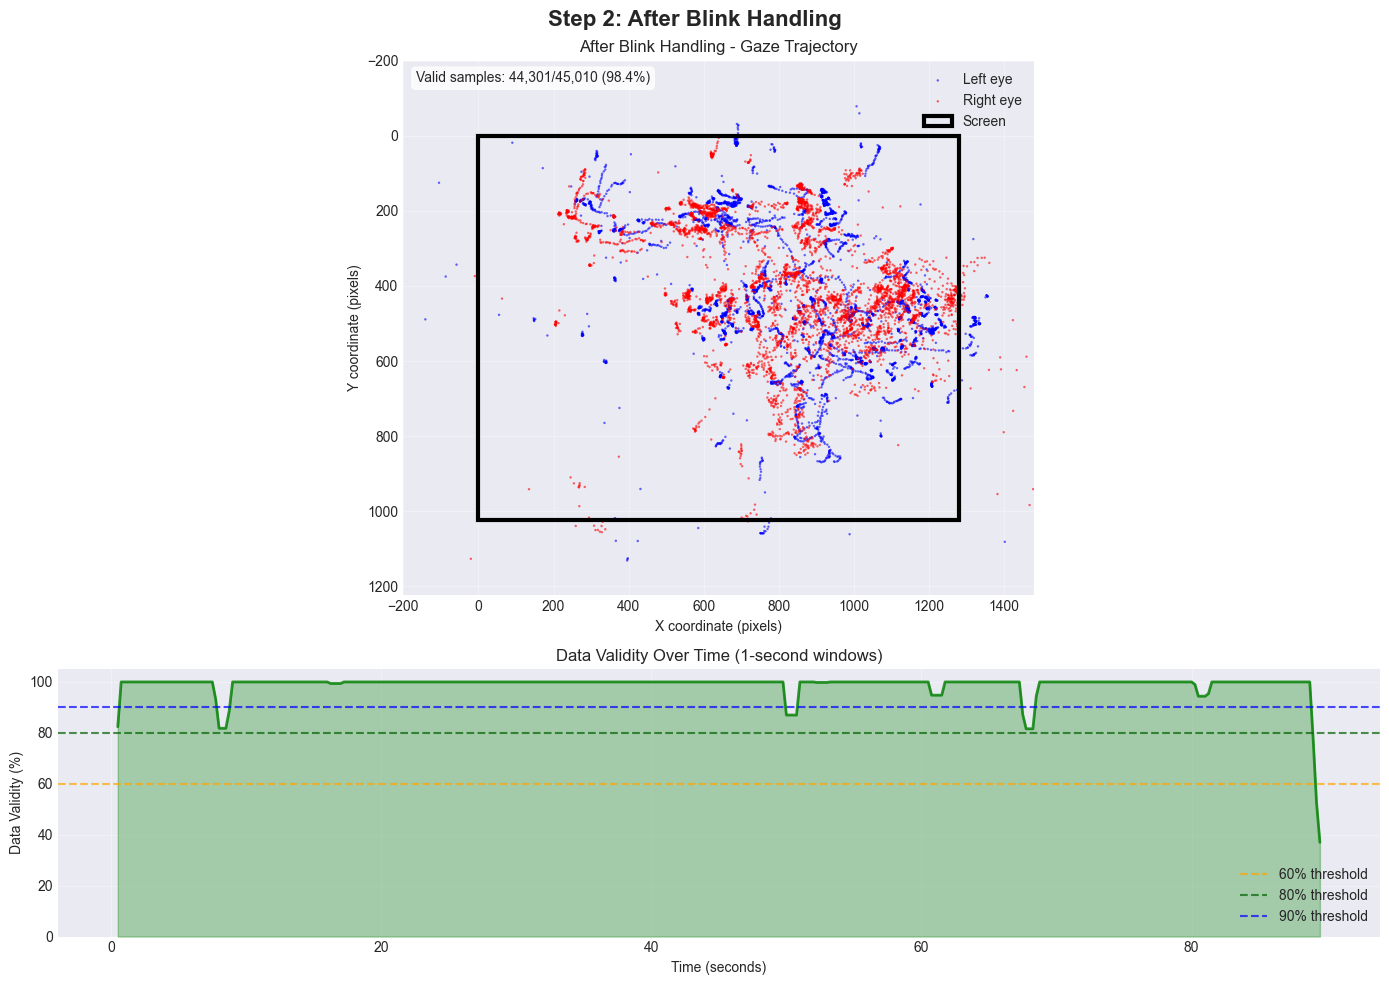

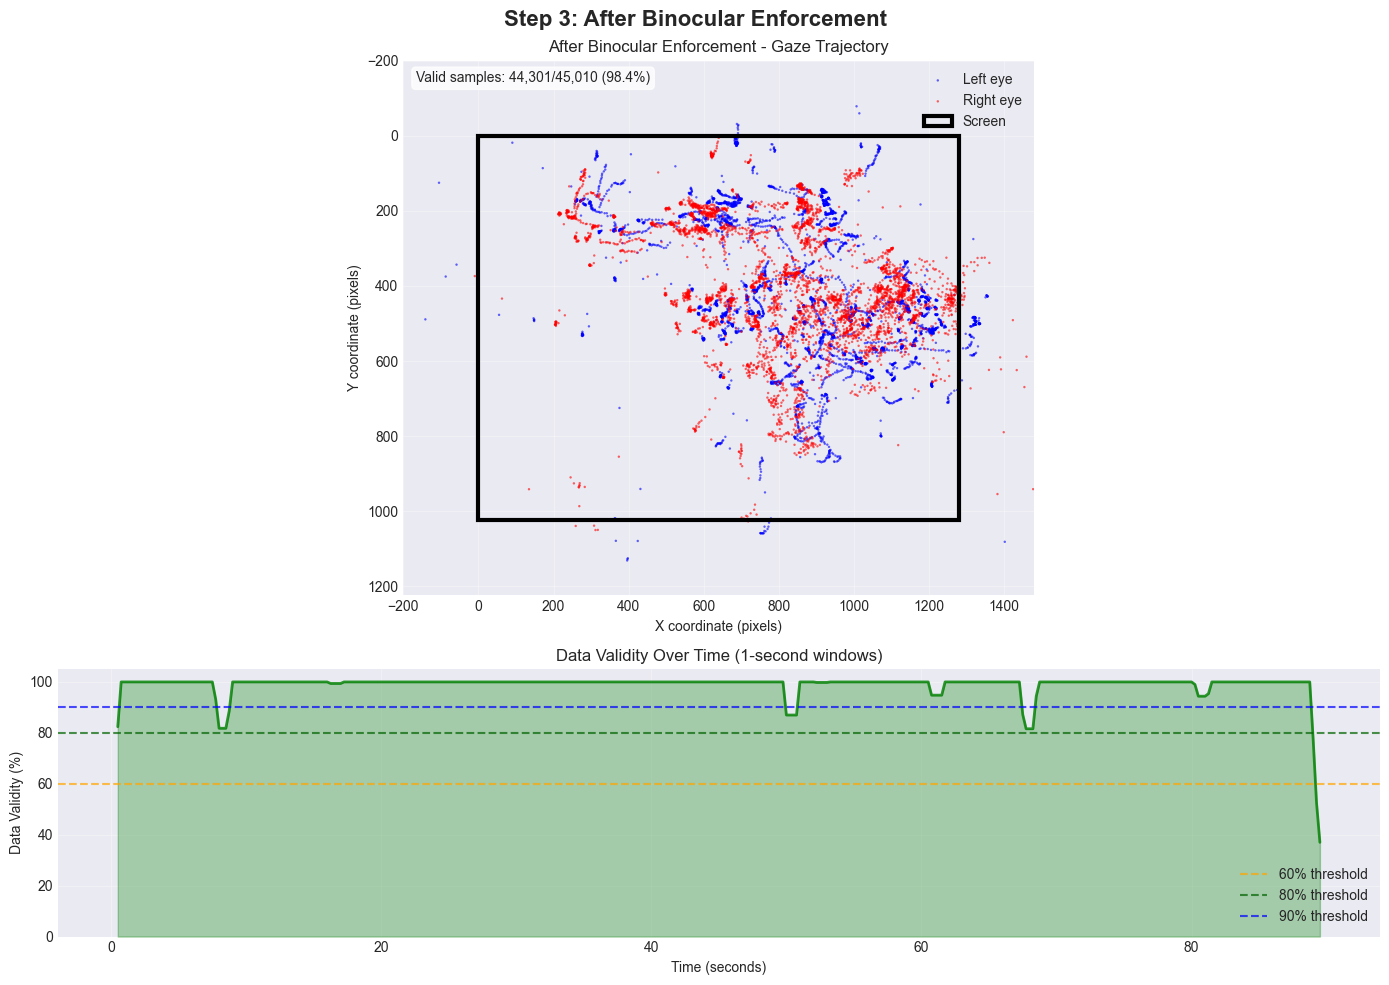

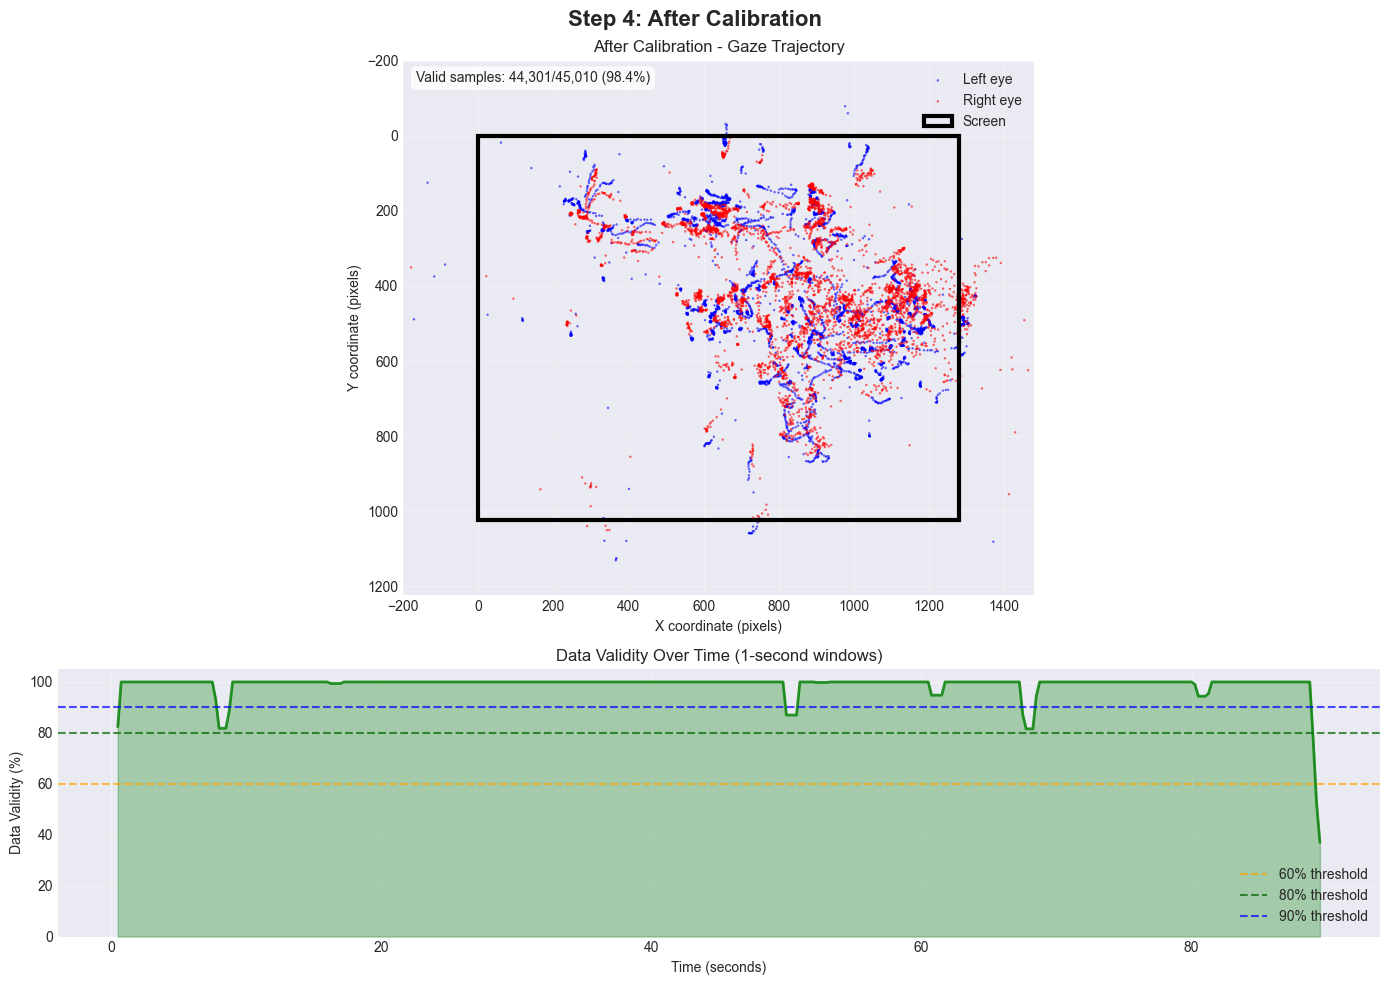

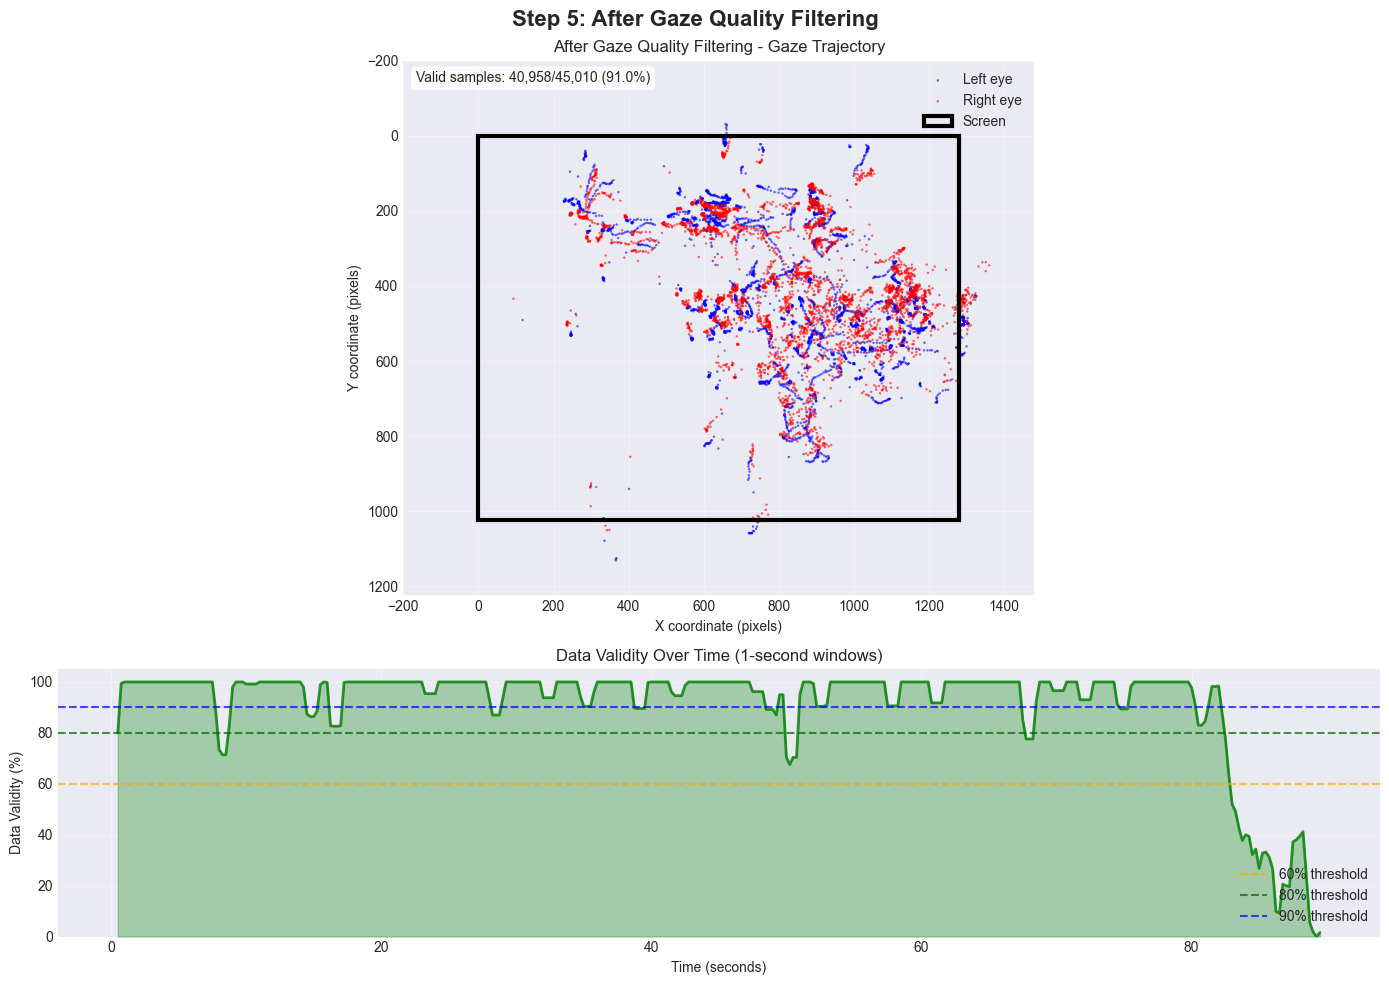

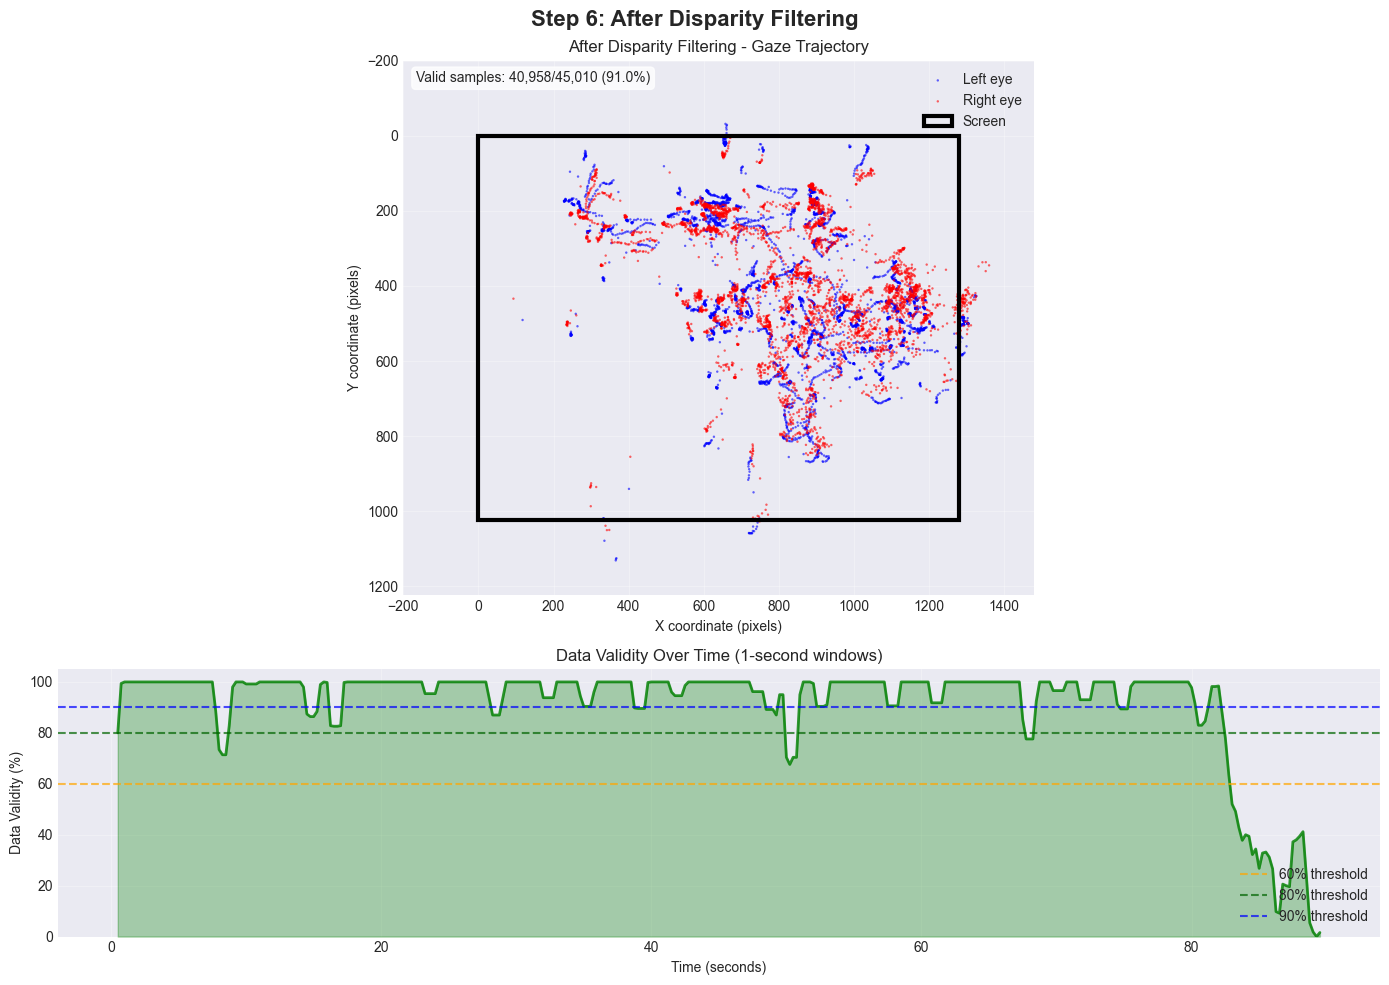

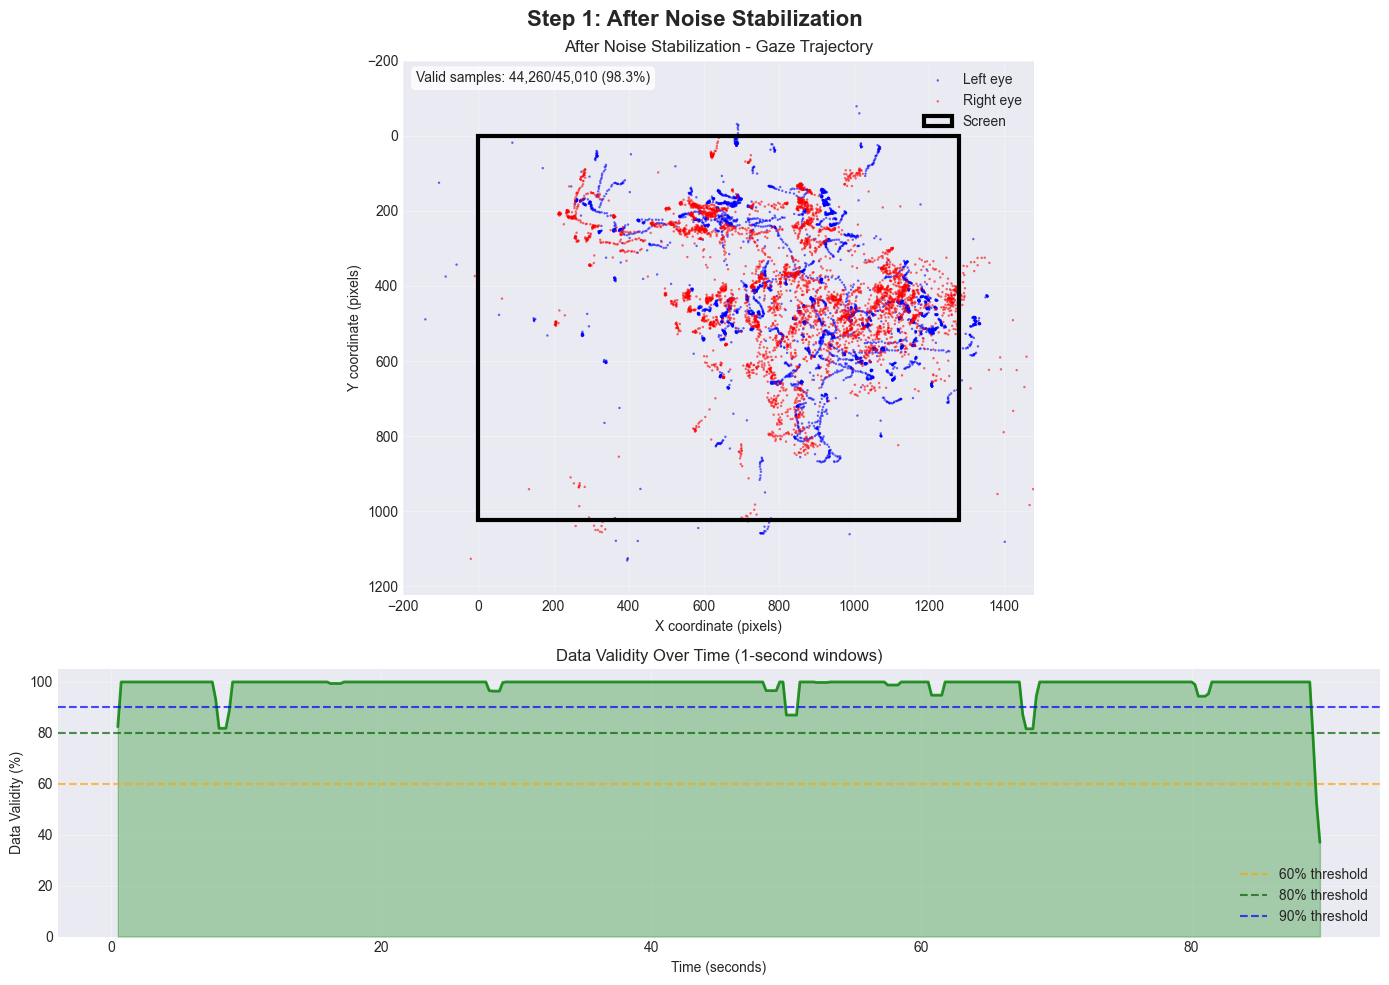

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>


✅ Created 6 individual preprocessing step plots!
📁 Plots saved to: figures/1024539343/individual_steps

Each plot shows:
- Upper subplot: Gaze trajectory (before/after side by side)
- Lower subplot: Validity over time


In [18]:
# Call the existing plot_individual_preprocessing_steps function to create the 6 plots
if len(glob.glob(os.path.join(DATA_DIR, '*.csv'))) > 0:
    # Get first available file and process it to get pipeline stages
    sample_file = glob.glob(os.path.join(DATA_DIR, '*.csv'))[0]
    
    print(f"\n🎨 Creating 6 individual preprocessing step plots...")
    print("="*60)
    
    # Process file to get pipeline stages (similar to the main preprocessing function)
    df = pd.read_csv(sample_file)
    subject_id = os.path.basename(sample_file).split('_')[0]
    df = remove_empty_columns(df, threshold=PREPROCESSING_PARAMS['missing_data_threshold'])
    df = add_helper_features(df)
    
    # Collect stages as they are processed
    pipeline_stages = []
    pipeline_titles = []
    
    # Stage 1: After noise stabilization
    df = detect_and_stabilize_noisy_eye(df, verbose=False)
    pipeline_stages.append(df.copy())
    pipeline_titles.append("After Noise Stabilization")
    
    # Stage 2: After blink handling
    df, _ = detect_and_handle_blinks(df, verbose=False)
    pipeline_stages.append(df.copy())
    pipeline_titles.append("After Blink Handling")
    
    # Stage 3: After binocular enforcement
    df = enforce_binocular_validity(df)
    pipeline_stages.append(df.copy())
    pipeline_titles.append("After Binocular Enforcement")
    
    # Stage 4: After calibration
    df, _ = automatic_binocular_calibration(df, verbose=False)
    pipeline_stages.append(df.copy())
    pipeline_titles.append("After Calibration")
    
    # Stage 5: After gaze quality filtering
    df = enforce_gaze_quality_constraints(df, verbose=False)
    pipeline_stages.append(df.copy())
    pipeline_titles.append("After Gaze Quality Filtering")
    
    # Stage 6: After disparity filtering
    df = remove_extreme_disparities(df)
    pipeline_stages.append(df.copy())
    pipeline_titles.append("After Disparity Filtering")
    
    # Create subject directory for saving plots
    subject_dir = os.path.join(FIGURE_DIR, subject_id, 'individual_steps')
    os.makedirs(subject_dir, exist_ok=True)
    
    # Call the existing function to create individual plots
    individual_figures = plot_individual_preprocessing_steps(
        pipeline_stages, 
        pipeline_titles,
        figsize=(14, 10),
        save_dir=subject_dir
    )
    
    # Display the plots
    for i, fig in enumerate(individual_figures):
        plt.figure(fig.number)
        plt.show()
        plt.close()  # Close to free memory
    
    print(f"\n✅ Created {len(individual_figures)} individual preprocessing step plots!")
    print(f"📁 Plots saved to: {subject_dir}")
    print("\nEach plot shows:")
    print("- Upper subplot: Gaze trajectory (before/after side by side)")
    print("- Lower subplot: Validity over time")

else:
    print("⚠️ No CSV files found in data directory")